In [ ]:
## integrate all datasets about party positioning (ideally all those that *don't* rely on inferences via electorate position)

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re, os, pickle

In [2]:
dataset_folder = "C:\\Users\\Marios\\Documents\\GitHub\\Thomas Prosser project\\datasets\\"
output_folder = "C:\\Users\\Marios\\Documents\\GitHub\\Thomas Prosser project\\output\\"

In [534]:
def could_be_int(x):
    if isinstance(x,float) or isinstance(x,int):
        return True
    else:
        try:
            int(x.strip())
            return True
        except:
            return False
        
def could_not_be_int(x):
    if isinstance(x,float) or isinstance(x,int):
        return False
    else:
        try:
            int(x.strip())
            return False
        except:
            return True        
        
def describe_messy_column(ser):

    nulls = ser.isnull().sum()
    print(nulls," nulls")
    ser = ser[ser.notnull()]
    vc = ser[ ser.apply(lambda x: could_not_be_int(x))].value_counts()
    display(vc[vc>0])
    print("min: ",ser[ ser.apply(lambda x: could_be_int(x))].min(),"max: ",ser[ ser.apply(lambda x: could_be_int(x))].max())
        

In [5]:
## (1) Comparative Manifesto Project CMP
# https://manifesto-project.wzb.eu/
Manifesto_Project_Dataset_version_2020a = "MPDataset_MPDS2020a_stata14.dta"

latest_CMP_file = dataset_folder+"CMP"+os.sep+Manifesto_Project_Dataset_version_2020a

manifest_project = pd.read_pickle(latest_CMP_file.replace("dta","zip"),compression='zip')
with open(latest_CMP_file.replace("dta","_labels.zip"), 'rb') as fname:
    CMP_labels = pickle.load(fname)
with open(latest_CMP_file.replace("dta","_header.zip"), 'rb') as fname:
    CMP_header = pickle.load(fname)

In [33]:
[x for x in manifest_project.columns if "tot" in x]
manifest_project["countryname"]

id_perm
JN1LZH          Sweden
CMR7F6          Sweden
Z6OL6C          Sweden
YMKVN2          Sweden
U4SCRD          Sweden
              ...     
FYLAK1    South Africa
SES5XV    South Africa
MEH5KV    South Africa
NU5PXG    South Africa
VKSFXI    South Africa
Name: countryname, Length: 4582, dtype: category
Categories (56, object): [Albania, Armenia, Australia, Austria, ..., Turkey, Ukraine, United Kingdom, United States]

In [712]:
# (2) Parties’ Immigration and Integration Positions Dataset (PImPo)
# https://manifesto-project.wzb.eu/information/documents/pimpo
# Codebook: https://manifesto-project.wzb.eu/down/datasets/pimpo/PImPo_codebook.pdf

PImPo=pd.read_stata( dataset_folder+"CMP"+os.sep+"PImPo_party.dta" )

party_name_dict = {'Familiy of the Irish':'Family of the Irish',
                   'Ourselves Alone':'We Ourselves',
                   "Maori Party":"Māori Party",
                   "Popular Party":"People's Party"}

def fix_PimPO_party_name(x):
    x = x.split(":")[1].strip()
    if x in party_name_dict.keys():
        x = party_name_dict[x]
    x = re.sub("\x92","’",x)
    x = re.sub("\x91","‘",x)
    return x


# I think we should keep the party column as a unique int
PImPo["partyname"]= PImPo["party"].apply(fix_PimPO_party_name)
PImPo["party"] = PImPo["party"].apply(lambda x: int(x.split(".")[0])).astype('int')

# country -> matches on countryname, force lowercase and it matches on country (one fix needed for "USA"->"United States")
PImPo["countryname"] = PImPo["country"].replace({"USA":"United States"})#.apply(lambda x: x.lower())
PImPo["country"] = PImPo["country"].replace({"USA":"United States"}).apply(lambda x: x.lower())

# party -> already matches
# date -> should add edate
PImPo["edate"] = pd.to_datetime(PImPo["date"],format = "%Y%m")

# 242 x 14 - not a big dataset at all!
# 14 countries, 1998-2013

# date Election date
# totals Total QS coded
# totals_immi Total QS on immigration
# totals_inti Total QS on integration
# saliency Overall saliency immi + inte
#     Comments: saliency is calculated as the proportion of immigration and
#     integration related quasi-sentences to the total number of quasi-sentences
# saliency_immi Saliency immigration
#     Comments: saliency of immigration is calculated as the proportion of
#     immigration related quasi-sentences to the total number of quasi-sentences.
# saliency_inti Saliency integration
#     Comments: saliency of integration is calculated as the proportion of
#     integration related quasi-sentences to the total number of quasi-sentences.
# immi_pos Immigration position
#     Comments: immigration position is calculated by subtracting the share of
#     sceptical quasi-sentences from the share of supportive quasi-sentences and
#     dividing this by the share of these two plus the share of the neutral
#     quasi-sentences.
# immi_pos_saliency (unlabeled)
#     Comments: gives the percentage of directional quasi-sentences. It is
#     calculated by adding the supportive and the sceptical immigration quasisentences and dividing them by all immigration quasi-sentence (supportive,
#     sceptical and neutral).
# inti_pos Integration position
#     Comments: integration position is calculated by subtracting the share of
#     sceptical quasi-sentences from the share of supportive quasi-sentences and
#     dividing this by the share of these two plus the share of the neutral
#     quasi-sentences.
# inti_pos_saliency (unlabeled)
#     Comments: gives the percentage of directional quasi-sentences. It is
#     calculated by adding the supportive and the sceptical integration quasisentences and dividing them by all integration quasi-sentence (supportive,
#     sceptical and neutral)

partyfacts_cmp = partyfacts_external_parties[partyfacts_external_parties["dataset_key"]=="manifesto"]
cmp_to_partyfacts_id = partyfacts_cmp[["dataset_party_id","partyfacts_id"]].astype(int).set_index("dataset_party_id")
PImPo["partyfacts_id"] = PImPo["party"].apply(lambda x: cmp_to_partyfacts_id.loc[x])
# # full coverage!

PImPo.to_pickle( dataset_folder+"CMP"+os.sep+"PImPo_linked.zip", compression='zip' )

In [726]:
pvds_parties["party"][pvds_parties["party"]!=-99].astype(int)[pvds_parties["party"][pvds_parties["party"]!=-99].astype(int).apply(lambda x: x not in cmp_to_partyfacts_id.index)].unique()

# these are older versions of cmp_ids - can be updated manually by looking at older cmp datasets/manually matching!

array([21031, 21051, 21092, 31061, 51041, 53051])

In [22]:
# (3) Government Declaration Dataset (GDDS)
# https://manifesto-project.wzb.eu/information/documents/gdds
# codebook: https://manifesto-project.wzb.eu/down/datasets/gdds/gdds_codebook.pdf

GDDS = pd.read_stata( dataset_folder+"CMP"+os.sep+"gdds.dta" )

# 174 x 62

# at some point have to link governments with parties

In [24]:
GDDS

# country -> country code id
# countryname -> country (starts with capital)
# govid -> unique gov id
# inaugdate -> inauguration of the government
# total -> same column

# need a resource like parlgov to link governments to parties!

Index(['country', 'countryname', 'govid', 'inaugdat', 'total', 'peruncod',
       'per101', 'per102', 'per103', 'per104', 'per105', 'per106', 'per107',
       'per108', 'per109', 'per110', 'per201', 'per202', 'per203', 'per204',
       'per301', 'per302', 'per303', 'per304', 'per305', 'per401', 'per402',
       'per403', 'per404', 'per405', 'per406', 'per407', 'per408', 'per409',
       'per410', 'per411', 'per412', 'per413', 'per414', 'per415', 'per416',
       'per501', 'per502', 'per503', 'per504', 'per505', 'per506', 'per507',
       'per601', 'per602', 'per603', 'per604', 'per605', 'per606', 'per607',
       'per608', 'per701', 'per702', 'per703', 'per704', 'per705', 'per706'],
      dtype='object')

In [82]:
# (4) Euromanifesto / Manifesto Project mapping scheme
# This is only the *2014* wave - there's also 2009 and 1979-2004 - unclear if they use the same mapping, but one thing at a time

euromanifesto = pd.read_stata( dataset_folder+"CMP"+os.sep+"ZA5162_v1-0-0.dta" )


# 199 x 764

In [83]:
em_to_mcp_mapping = pd.read_csv( dataset_folder+"CMP"+os.sep+"emp_mpds_mapping.csv" )
em_to_mcp_mapping = em_to_mcp_mapping[['emp_2014', 'value', 'mp_hb4', 'mp_hb5']]

In [84]:
euromanifesto[euromanifesto.columns[20:40]].describe(include='all')

# version, doi, year - single value per dataset indicators
# za_nr? GESIS ZA study number (ZA5162)
# country: 29
# region: 31
# country_year: country_year code pairs
# emcs, emcs_year: unique identifiers for the party (EuroManifesto Coding Scheme)
# ees: nearly unique ids, but some codes missing
# marpor: looks like manifesto project party codes
# cphl: another party code set???
# eep: year of a country’s first elections to the European Parliament
# member: Year of a country’s first admittance to the European Parliament
# initials: party abbreviation (not unique!)
# year: Election year.
# initials: Party initials.
# partyname: Party name.
# partyinfo: Information on changes in party names.
# pfamily: Party family (Euromanifesto Project).
# mfamily: Party family according to MARPOR.
# ofamily: Party family at origin (Euromanifesto Project).
# EPvote: Percentage of EEP votes at national level.
# EPseats: Number of seats in the European Parliament.
# EPseatsum: Overall number of seats in the European Parliament by country.
# group: Affiliation to a political group at European level (European party).
# manif: Type of manifesto coded.
# NATvote: Percentage of votes in the last national parliamentary elections
# NATseats: Number of seats in the national parliament
# gov: Member party of the national government at time of the EP election
# pm: National Prime Minister is member of this party



# 'per_v1_7064b'
# per_v(1|2|3) -> 1=National, 2=European, 3=General
# b is negative, a is positive

,EPvote,EPseats,EPseatsum,group,manif,NATvote,NATseats,gov,pm,left,environ,liberta,religious,state,multicult,integration,pubservice,redistribut,liberties,lifestyle
count,199,199,199,199,199,199,199,199,199,199,199,199,199,199,199,199,199,199,199,199
unique,177,23,16,9,4,147,76,3,3,11,11,11,11,11,11,11,11,11,11,11
top,Inapplicable,1,21,EPP: Group of the European People's Party,Proper Euromanifesto,Did not compete,0,No member party of the national government at ...,National HoG does not belong to that party at ...,3,3,3,No answer,3,2,2,No answer,No answer,No answer,No answer
freq,6,65,38,43,175,12,27,133,167,30,28,39,95,43,37,53,49,41,30,74


In [87]:
# em_to_mcp_mapping.set_index("emp_2014")["mp_hb5"].apply()

In [88]:
no_mapping = (em_to_mcp_mapping["mp_hb5"]=="0")
em_to_mcp_mapping["latest"] = em_to_mcp_mapping["mp_hb5"]
em_to_mcp_mapping.loc[no_mapping,"latest"] = "emp_"+em_to_mcp_mapping.loc[no_mapping,"emp_2014"]

In [89]:
mapping_dictionary = em_to_mcp_mapping.set_index("emp_2014")["latest"].to_dict()
# euromanifesto.columns.map(mapping_dictionary)

Index([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       ...
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
      dtype='object', length=764)

In [90]:
euromanifesto.rename(columns=mapping_dictionary)

,za_nr,version,doi,country,region,country_year,emcs,emcs_year,ees,marpor,...,per_v3_7063b,per_v1_7063a,per_v2_7063a,per_v3_7063a,per_v1_7064b,per_v2_7064b,per_v3_7064b,per_v1_7064a,per_v2_7064a,per_v3_7064a
0,5162.0,1.0.0 (2016-07-28),doi:10.4232/1.5162,Europe,Europe,10_14,10100 GREEN-EFA,10100_14,No EES code available,Unavailable,...,0,0.000000,0.797267,0.113895,0.0,0.0,0,0.0,0.0,0.113895
1,5162.0,1.0.0 (2016-07-28),doi:10.4232/1.5162,Europe,Europe,10_14,10300 PES,10300_14,No EES code available,Unavailable,...,0,0.000000,2.764977,0.000000,0.0,0.0,0,0.0,0.0,0.000000
2,5162.0,1.0.0 (2016-07-28),doi:10.4232/1.5162,Europe,Europe,10_14,10400 ALDE,10400_14,No EES code available,Unavailable,...,0,0.000000,0.911854,0.000000,0.0,0.0,0,0.0,0.0,0.000000
3,5162.0,1.0.0 (2016-07-28),doi:10.4232/1.5162,Europe,Europe,10_14,10600 EPP,10600_14,No EES code available,Unavailable,...,0,0.000000,0.523560,0.000000,0.0,0.0,0,0.0,0.0,0.000000
4,5162.0,1.0.0 (2016-07-28),doi:10.4232/1.5162,Europe,Europe,10_14,10610 ECR,10610_14,No EES code available,Unavailable,...,0,0.000000,0.226501,0.000000,0.0,0.0,0,0.0,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
194,5162.0,1.0.0 (2016-07-28),doi:10.4232/1.5162,Slovenia,Slovenia,97_14,97321 SD,97321_14,1705323 SD,97321,...,0,0.653595,0.653595,1.307190,0.0,0.0,0,0.0,0.0,0.000000
195,5162.0,1.0.0 (2016-07-28),doi:10.4232/1.5162,Slovenia,Slovenia,97_14,97411 Verjamem,97411_14,1705100 Verjamem,Unknown,...,0,0.000000,0.000000,0.000000,0.0,0.0,0,0.0,0.0,0.000000
196,5162.0,1.0.0 (2016-07-28),doi:10.4232/1.5162,Slovenia,Slovenia,97_14,97431 Zares,97431_14,1705324 Zares,97440,...,0,0.000000,0.000000,0.000000,0.0,0.0,0,0.0,0.0,0.000000
197,5162.0,1.0.0 (2016-07-28),doi:10.4232/1.5162,Slovenia,Slovenia,97_14,97510 NSi-SLS,97510_14,1705001 NSi-SLS,Unknown,...,0,0.000000,0.000000,0.000000,0.0,0.0,0,0.0,0.0,0.000000


In [95]:
euromanifesto[ euromanifesto.columns[3:20] ]

,country,region,country_year,emcs,emcs_year,ees,marpor,cphl,eep,member,year,initials,partyname,partyinfo,pfamily,mfamily,ofamily
0,Europe,Europe,10_14,10100 GREEN-EFA,10100_14,No EES code available,Unavailable,Unavailable,Inapplicable,Inapplicable,2014.0,GREEN-EFA,Group of the Greens - European Free Alliance,,Green Parties,Unavailable,Green Parties
1,Europe,Europe,10_14,10300 PES,10300_14,No EES code available,Unavailable,Unavailable,Inapplicable,Inapplicable,2014.0,PES,Party of European Socialists,,Social Democratic Parties,Unavailable,Social Democratic Parties
2,Europe,Europe,10_14,10400 ALDE,10400_14,No EES code available,Unavailable,Unavailable,Inapplicable,Inapplicable,2014.0,ALDE,Group of the Alliance of Liberals and Democrat...,,Liberal Parties,Unavailable,Liberal Parties
3,Europe,Europe,10_14,10600 EPP,10600_14,No EES code available,Unavailable,Unavailable,Inapplicable,Inapplicable,2014.0,EPP,European People's Party,1953-1979: CD (Christian Democrats); 1979-1999...,Christian Democratic Parties,Unavailable,Conservative Parties
4,Europe,Europe,10_14,10610 ECR,10610_14,No EES code available,Unavailable,Unavailable,Inapplicable,Inapplicable,2014.0,ECR,European Conservatives and Reformist Group,,Conservative Parties,Unavailable,Conservative Parties
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
194,Slovenia,Slovenia,97_14,97321 SD,97321_14,1705323 SD,97321,2903,2004,2004,2014.0,SD,Socialni Demokrati,1993-2005: ZLSD (Združena Lista Socialnih Demo...,Social Democratic Parties,Social Democratic,Social Democratic Parties
195,Slovenia,Slovenia,97_14,97411 Verjamem,97411_14,1705100 Verjamem,Unknown,Unknown,2004,2004,2014.0,Verjamem,Verjamem,,Liberal Parties,Unknown,Unknown
196,Slovenia,Slovenia,97_14,97431 Zares,97431_14,1705324 Zares,97440,2910,2004,2004,2014.0,Zares,Zares,,Liberal Parties,Liberal,Liberal Parties
197,Slovenia,Slovenia,97_14,97510 NSi-SLS,97510_14,1705001 NSi-SLS,Unknown,Unknown,2004,2004,2014.0,NSi-SLS,Nova Slovenija - Slovenska Ljudska Stranka,,Agrarian Parties,Christian Democratic,Unknown


In [87]:
[x for x in euromanifesto.columns if x in mapping_dictionary.keys()]

['per_v_6012']

In [107]:
euromanifesto.columns[0:40]

Index(['za_nr', 'version', 'doi', 'country', 'region', 'country_year', 'emcs',
       'emcs_year', 'ees', 'marpor', 'cphl', 'eep', 'member', 'year',
       'initials', 'partyname', 'partyinfo', 'pfamily', 'mfamily', 'ofamily',
       'EPvote', 'EPseats', 'EPseatsum', 'group', 'manif', 'NATvote',
       'NATseats', 'gov', 'pm', 'left', 'environ', 'liberta', 'religious',
       'state', 'multicult', 'integration', 'pubservice', 'redistribut',
       'liberties', 'lifestyle'],
      dtype='object')

In [112]:

party_code_replace_dict = {"Unknown":np.nan,"No EES code available":np.nan,"Unavailable":np.nan}
print(euromanifesto.shape)
euromanifesto[["emcs","emcs_year","ees","cphl","marpor"]].replace(party_code_replace_dict).isnull().sum()


# "country","partyname",

euromanifesto[["ees","cphl","marpor"]].replace(party_code_replace_dict).isnull().all(axis=1).sum()
# no external link in 19 cases!

euromanifesto[["cphl","marpor"]].replace(party_code_replace_dict).isnull().all(axis=1).sum()
# 39 with these two


euromanifesto[["marpor"]].replace(party_code_replace_dict).isnull().all(axis=1).sum()
# euromanifesto[["marpor"]]

(199, 764)


56

In [101]:
euromanifesto

,za_nr,version,doi,country,region,country_year,emcs,emcs_year,ees,marpor,...,per_v3_7063b,per_v1_7063a,per_v2_7063a,per_v3_7063a,per_v1_7064b,per_v2_7064b,per_v3_7064b,per_v1_7064a,per_v2_7064a,per_v3_7064a
0,5162.0,1.0.0 (2016-07-28),doi:10.4232/1.5162,Europe,Europe,10_14,10100 GREEN-EFA,10100_14,No EES code available,Unavailable,...,0,0.000000,0.797267,0.113895,0.0,0.0,0,0.0,0.0,0.113895
1,5162.0,1.0.0 (2016-07-28),doi:10.4232/1.5162,Europe,Europe,10_14,10300 PES,10300_14,No EES code available,Unavailable,...,0,0.000000,2.764977,0.000000,0.0,0.0,0,0.0,0.0,0.000000
2,5162.0,1.0.0 (2016-07-28),doi:10.4232/1.5162,Europe,Europe,10_14,10400 ALDE,10400_14,No EES code available,Unavailable,...,0,0.000000,0.911854,0.000000,0.0,0.0,0,0.0,0.0,0.000000
3,5162.0,1.0.0 (2016-07-28),doi:10.4232/1.5162,Europe,Europe,10_14,10600 EPP,10600_14,No EES code available,Unavailable,...,0,0.000000,0.523560,0.000000,0.0,0.0,0,0.0,0.0,0.000000
4,5162.0,1.0.0 (2016-07-28),doi:10.4232/1.5162,Europe,Europe,10_14,10610 ECR,10610_14,No EES code available,Unavailable,...,0,0.000000,0.226501,0.000000,0.0,0.0,0,0.0,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
194,5162.0,1.0.0 (2016-07-28),doi:10.4232/1.5162,Slovenia,Slovenia,97_14,97321 SD,97321_14,1705323 SD,97321,...,0,0.653595,0.653595,1.307190,0.0,0.0,0,0.0,0.0,0.000000
195,5162.0,1.0.0 (2016-07-28),doi:10.4232/1.5162,Slovenia,Slovenia,97_14,97411 Verjamem,97411_14,1705100 Verjamem,Unknown,...,0,0.000000,0.000000,0.000000,0.0,0.0,0,0.0,0.0,0.000000
196,5162.0,1.0.0 (2016-07-28),doi:10.4232/1.5162,Slovenia,Slovenia,97_14,97431 Zares,97431_14,1705324 Zares,97440,...,0,0.000000,0.000000,0.000000,0.0,0.0,0,0.0,0.0,0.000000
197,5162.0,1.0.0 (2016-07-28),doi:10.4232/1.5162,Slovenia,Slovenia,97_14,97510 NSi-SLS,97510_14,1705001 NSi-SLS,Unknown,...,0,0.000000,0.000000,0.000000,0.0,0.0,0,0.0,0.0,0.000000


In [90]:
 [x for x in euromanifesto.columns if "7063" in x]

['per_v1_7063b',
 'per_v2_7063b',
 'per_v3_7063b',
 'per_v1_7063a',
 'per_v2_7063a',
 'per_v3_7063a']

In [117]:
## (5) parlgov - updated as of 10/08/2020!

parlgov_party = pd.read_excel(dataset_folder+"PARLGOV"+os.sep+ "parlgov.xlsx",sheet_name="party")
parlgov_election = pd.read_excel(dataset_folder+"PARLGOV"+os.sep+ "parlgov.xlsx",sheet_name="election")
parlgov_cabinet = pd.read_excel(dataset_folder+"PARLGOV"+os.sep+ "parlgov.xlsx",sheet_name="cabinet")
parlgov_variable = pd.read_excel(dataset_folder+"PARLGOV"+os.sep+ "parlgov.xlsx",sheet_name="variable")
# party, election, cabinet, variable

In [118]:
parlgov_party.shape

(1651, 23)

In [138]:
parlgov_party

,country_name_short,country_name,party_name_short,party_name_english,party_name,party_name_ascii,family_name_short,family_name,left_right,state_market,...,euprofiler,ees,castles_mair,huber_inglehart,ray,benoit_laver,chess,country_id,party_id,family_id
0,AUS,Australia,ACP-V,Australian Country Party (Vic),Australian Country Party (Vic),Australian Country Party (Vic),con,Conservative,7.4000,6.4000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,33,1935,26
1,AUS,Australia,AD,Australian Democrats,Australian Democrats,Australian Democrats,soc,Social democracy,3.7004,3.3684,...,NaN,NaN,102.0,203.0,NaN,4703.0,NaN,33,120,11
2,AUS,Australia,AG,Australian Greens,Australian Greens,Australian Greens,eco,Green/Ecologist,1.5439,1.2982,...,NaN,NaN,NaN,NaN,NaN,4739.0,NaN,33,751,19
3,AUS,Australia,ALP,Australian Labor Party,Australian Labor Party,Australian Labor Party,soc,Social democracy,3.8833,4.0351,...,NaN,NaN,101.0,NaN,NaN,4721.0,NaN,33,1253,11
4,AUS,Australia,AP,Australia Party,Australia Party,Australia Party,lib,Liberal,6.0000,6.7000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,33,1760,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1646,TUR,Turkey,SHP|CHP,Social Democratic Populist Party | Republican ...,Sosyal Demokrat Halçi Parti | Cumhuriyet Halk ...,Sosyal Demokrat Halci Parti | Cumhuriyet Halk ...,soc,Social democracy,3.2661,2.8138,...,307.0,NaN,NaN,4004.0,NaN,8184.0,3402.0,20,507,11
1647,TUR,Turkey,SP,Felicity Party,Saadet Partisi,Saadet Partisi,con,Conservative,7.4000,6.4000,...,316.0,NaN,NaN,NaN,NaN,NaN,NaN,20,1315,26
1648,TUR,Turkey,YTP,New Turkey Party,Yeni Türkiye Partisi,Yeni Turkiye Partisi,soc,Social democracy,3.3000,3.5000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20,2304,11
1649,TUR,Turkey,no-seat,no seat,no seat,no seat,none,no family,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20,2316,12


In [116]:
parlgov_party[parlgov_party.columns[12:30]]

,cmp,euprofiler,ees,castles_mair,huber_inglehart,ray,benoit_laver,chess,country_id,party_id,family_id
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,33,1935,26
1,63321.0,NaN,NaN,102.0,203.0,NaN,4703.0,NaN,33,120,11
2,NaN,NaN,NaN,NaN,NaN,NaN,4739.0,NaN,33,751,19
3,63320.0,NaN,NaN,101.0,NaN,NaN,4721.0,NaN,33,1253,11
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,33,1760,6
...,...,...,...,...,...,...,...,...,...,...,...
1646,74321.0,307.0,NaN,NaN,4004.0,NaN,8184.0,3402.0,20,507,11
1647,NaN,316.0,NaN,NaN,NaN,NaN,NaN,NaN,20,1315,26
1648,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20,2304,11
1649,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20,2316,12


In [ ]:
# Election Level do-file
# codebook: https://manifesto-project.wzb.eu/down/do_files/mpelds_documentation.pdf
# STATA do-file: https://manifesto-project.wzb.eu/down/do_files/mpelds.do

# rewrite for Python?

In [ ]:
## Uncertainty measures

In [ ]:
# https://manifesto-project.wzb.eu/information/documents/external_extensions

In [ ]:
# Left-Right Measures based on Manifesto Project Data
# whole bunch of papers using the data to build left-right scaling models

In [ ]:
## Woldendorp, Keman and Budge (2000) Party Government data set updated through 2014:
# http://faculty.missouri.edu/williamslaro/govtdata.html

In [ ]:
## `Most Important Problem' Dataset updated through June 2015 (America, 1939-2015)
# http://faculty.missouri.edu/~williamslaro/mipdata.html

In [ ]:
## (7) Party Facts (Insane number of attachable datasets through )
# https://partyfacts.herokuapp.com/data/
# latest linking - 2 days ago - 2020-08-09 07:39:10.333407+00:00

In [121]:
partyfacts_core_parties = pd.read_csv(dataset_folder+"PartyFacts"+os.sep+ "partyfacts-core-parties.csv")
partyfacts_external_parties = pd.read_csv(dataset_folder+"PartyFacts"+os.sep+ "partyfacts-external-parties.csv")
partyfacts_countries = pd.read_csv(dataset_folder+"PartyFacts"+os.sep+ "partyfacts-countries.csv")
partyfacts_datasets = pd.read_csv(dataset_folder+"PartyFacts"+os.sep+ "partyfacts-datasets.csv")

In [139]:
partyfacts_core_parties

,country,partyfacts_id,technical,name_short,name,name_english,name_other,year_first,year_last,share,share_year,new,wikipedia,description,comment,created,modified
0,AFG,6641,NaN,SDP,Afğān Millat Gund,Afghan Social Democratic Party / Afghan Millat...,Pashto: افغان ټولنپال ولسواک ګوند‎ / افغان ملت...,1966,NaN,1.6,2010.0,NaN,https://en.wikipedia.org/wiki/Afghan_Millat_Party,4/249 seats in the 2010 Afghan parliamentary e...,NaN,2019-02-02 19:46:04.587339+00:00,2019-02-02 19:47:21.342072+00:00
1,AFG,8281,NaN,HW,Hizbi Watan,Fatherland Party,NaN,1990,1992.0,NaN,NaN,NaN,NaN,President & Prime minister 1990 - 1992,NaN,2020-03-31 10:37:47.193372+00:00,2020-03-31 10:42:50.475638+00:00
2,AFG,6642,NaN,IMA,Harakat-e Islami-yi Afghanistan,Islamic Movement of Afghanistan,Persian: حرکت اسلامی افغانستان‎,1978,NaN,1.6,2010.0,NaN,https://en.wikipedia.org/wiki/Islamic_Movement...,4/249 seats in the 2010 Afghan parliamentary e...,NaN,2019-02-02 19:53:35.410246+00:00,2019-02-02 19:53:35.410307+00:00
3,AFG,6643,NaN,HI,Hezb-e Islami,Islamic Party,NaN,1975,NaN,4.8,2005.0,NaN,https://en.wikipedia.org/wiki/Hezbi_Islami,12/249 seats in the 2005 Afghan parliamentary ...,NaN,2019-02-02 20:04:51.631557+00:00,2019-02-02 20:04:51.631606+00:00
4,AFG,5183,NaN,JI,Jamiat-e Islami,Islamic Society,Persian: جمعیت اسلامی افغانستان‎‎;,1968,NaN,23.7,1993.0,NaN,https://en.wikipedia.org/wiki/Jamiat-e_Islami,NaN,NaN,2016-08-16 13:03:18.604439+00:00,2018-11-16 08:35:37.800869+00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6897,ZWE,3551,12.0,tech,technical,technical,NaN,1800,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2015-07-20 22:23:04.422439+00:00,2020-07-16 15:49:20.133307+00:00
6898,ZWE,3550,11.0,1-perc,1 percent,1 percent,NaN,1800,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2015-07-20 22:23:04.400755+00:00,2020-07-16 15:49:20.101351+00:00
6899,ZWE,3549,10.0,unknown,unknown,unknown,NaN,1800,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2015-07-20 22:23:04.380627+00:00,2020-07-16 15:49:20.064241+00:00
6900,ZWE,3547,8.0,indep,independent,independent,NaN,1800,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2015-07-20 22:23:04.336451+00:00,2020-07-16 15:49:20.004920+00:00


In [122]:
partyfacts_external_parties

# party_id - not unique

# dataset_party_id - not unique
# external_id - unique id
# - I'm not totally clear which of these would appear in the external dataset!

# 25319 x 17
# 45 datsets, 213 countries


# I think external_id is the unique identifier for all 'external parties'
# all external parties have a link to a core party 'partyfacts_id'

# dataset_key+dataset_party_id pairs are unique

,country,dataset_key,dataset_party_id,name_short,name,name_english,year_first,year_last,share,share_year,description,comment,created,modified,external_id,partyfacts_id,linked
0,ALB,manifesto,75810,PASH,Partia Agrare e Shqipërisë,Agrarian Party of Albania,1991,2001,2.6,2001.0,NaN,NaN,2013-01-01 18:17:39.471000+00:00,2018-11-11 22:23:20.246061+00:00,1789,840,2013-01-01 18:33:17.491000+00:00
1,ALB,manifesto,75722,PRSH,Partia Republikane Shqiptare,Albanian Republican Party,1991,1997,5.7,1996.0,NaN,NaN,2013-01-01 18:17:52.743000+00:00,2018-11-11 22:23:20.267393+00:00,1853,819,2013-01-01 18:33:18.723000+00:00
2,ALB,manifesto,75220,PPS,Partia Socialiste e Shqipërisë,Albanian Socialist Party,1991,2001,56.2,1991.0,NaN,NaN,2013-01-01 18:17:23.706000+00:00,2018-11-11 22:23:20.285590+00:00,1715,1729,2019-05-27 13:22:39.391437+00:00
3,ALB,manifesto,75421,AD,Partia Aleanca Demokratike,Democratic Alliance Party,1992,2001,2.7,1997.0,NaN,NaN,2013-01-01 18:17:37.134000+00:00,2018-11-11 22:23:20.304044+00:00,1778,594,2014-02-09 12:46:36.901910+00:00
4,ALB,manifesto,75624,PD,Partia Demokratike e Shqipërisë,Democratic Party of Albania,1991,1997,62.1,1992.0,NaN,NaN,2013-01-01 18:16:44.165000+00:00,2018-11-11 22:23:20.321847+00:00,1533,190,2014-02-09 13:21:50.939526+00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25314,GBR,thomas,50,NaN,NaN,Labour,1910,1960,NaN,NaN,NaN,NaN,2016-01-13 17:49:21.851950+00:00,2018-11-11 22:31:09.251595+00:00,15894,1516,2016-01-14 07:49:53.398978+00:00
25315,GBR,thomas,51,NaN,NaN,Liberal,1870,1960,NaN,NaN,NaN,NaN,2016-01-13 17:49:21.945835+00:00,2018-11-11 22:31:09.283848+00:00,15898,540,2016-01-14 07:49:46.076712+00:00
25316,GBR,thomas,52,NaN,NaN,Liberal Unionist,1890,1890,NaN,NaN,NaN,NaN,2016-01-13 17:49:21.071136+00:00,2018-11-11 22:31:09.303907+00:00,15850,2120,2016-01-14 07:49:41.761384+00:00
25317,USA,thomas,53,NaN,NaN,Democratic,1870,1960,NaN,NaN,NaN,NaN,2016-01-13 17:49:21.536889+00:00,2018-11-11 22:31:09.320033+00:00,15876,432,2016-01-14 07:32:24.154001+00:00


In [148]:
partyfacts_external_parties[partyfacts_external_parties["dataset_key"]=="manifesto"]["dataset_party_id"]

# 1170 external parties listed for 'manifesto'

# comparative manifesto project main dataset ... only has 1154 unique parties!

,country,dataset_key,dataset_party_id,name_short,name,name_english,year_first,year_last,share,share_year,description,comment,created,modified,external_id,partyfacts_id,linked
0,ALB,manifesto,75810,PASH,Partia Agrare e Shqipërisë,Agrarian Party of Albania,1991,2001,2.6,2001.0,NaN,NaN,2013-01-01 18:17:39.471000+00:00,2018-11-11 22:23:20.246061+00:00,1789,840,2013-01-01 18:33:17.491000+00:00
1,ALB,manifesto,75722,PRSH,Partia Republikane Shqiptare,Albanian Republican Party,1991,1997,5.7,1996.0,NaN,NaN,2013-01-01 18:17:52.743000+00:00,2018-11-11 22:23:20.267393+00:00,1853,819,2013-01-01 18:33:18.723000+00:00
2,ALB,manifesto,75220,PPS,Partia Socialiste e Shqipërisë,Albanian Socialist Party,1991,2001,56.2,1991.0,NaN,NaN,2013-01-01 18:17:23.706000+00:00,2018-11-11 22:23:20.285590+00:00,1715,1729,2019-05-27 13:22:39.391437+00:00
3,ALB,manifesto,75421,AD,Partia Aleanca Demokratike,Democratic Alliance Party,1992,2001,2.7,1997.0,NaN,NaN,2013-01-01 18:17:37.134000+00:00,2018-11-11 22:23:20.304044+00:00,1778,594,2014-02-09 12:46:36.901910+00:00
4,ALB,manifesto,75624,PD,Partia Demokratike e Shqipërisë,Democratic Party of Albania,1991,1997,62.1,1992.0,NaN,NaN,2013-01-01 18:16:44.165000+00:00,2018-11-11 22:23:20.321847+00:00,1533,190,2014-02-09 13:21:50.939526+00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1165,URY,manifesto,162310,FA,Frente Amplio,Broad Front,2014,2014,49.4,2014.0,NaN,NaN,2019-01-22 16:59:35.138147+00:00,2019-01-22 16:59:35.138205+00:00,29042,1658,2019-01-22 17:11:00.458495+00:00
1166,URY,manifesto,162410,PC,Partido Colorado,Colorado Party,2014,2014,13.3,2014.0,NaN,NaN,2019-01-22 16:59:40.863004+00:00,2019-01-22 16:59:40.863233+00:00,29047,1419,2019-01-22 16:59:40.985587+00:00
1167,URY,manifesto,162510,PI,Partido Independiente,Independent Party,2014,2014,3.2,2014.0,NaN,NaN,2019-01-22 16:59:43.618412+00:00,2019-01-22 16:59:43.618470+00:00,29049,518,2019-01-22 16:59:43.704043+00:00
1168,URY,manifesto,162610,PN,Partido Nacional,National Party,2014,2014,31.9,2014.0,NaN,NaN,2019-01-22 16:59:56.031082+00:00,2019-01-22 16:59:56.031143+00:00,29064,118,2019-01-22 16:59:56.101714+00:00


In [193]:
pf_cmp_ids = set(partyfacts_external_parties[partyfacts_external_parties["dataset_key"]=="manifesto"]["dataset_party_id"].astype('int'))

cmp_cmp_ids = set(manifest_project["party"])
len(pf_cmp_ids), len(cmp_cmp_ids), len(pf_cmp_ids-cmp_cmp_ids), len(cmp_cmp_ids-pf_cmp_ids)

(1170, 1154, 57, 41)

In [198]:
manifest_project[manifest_project["party"].apply(lambda x: x not in pf_cmp_ids)]["edate"].value_counts().sort_index()

# party_ids in cmp not in party_facts
# seem to be predominantly newer!

2012-10-28    3
2014-05-25    1
2014-07-13    3
2015-06-18    1
2015-10-25    3
2016-10-29    1
2016-12-11    3
2017-09-11    1
2017-10-28    3
2018-03-04    6
2018-06-03    4
2018-06-24    2
2018-10-06    3
2018-10-07    3
2019-04-14    1
2019-04-28    4
2019-05-26    1
2019-10-20    1
2019-12-12    1
Name: edate, dtype: int64

In [202]:
temp = partyfacts_external_parties[partyfacts_external_parties["dataset_key"]=="manifesto"]["dataset_party_id"].apply(lambda x: x not in set(manifest_project["party"].astype(str)))

partyfacts_external_parties[partyfacts_external_parties["dataset_key"]=="manifesto"][temp]

# ["edate"].value_counts().sort_index()

# 'manifesto' ids in partyfacts not in manifesto dataset - mostly south america
# seem to be predominantly newer!

,country,dataset_key,dataset_party_id,name_short,name,name_english,year_first,year_last,share,share_year,description,comment,created,modified,external_id,partyfacts_id,linked
11,ARG,manifesto,150601,AR,Acción por la República,Action for the Republic,1999,1999,8.1,1999.0,NaN,NaN,2018-08-02 13:22:57.197286+00:00,2018-11-11 22:23:20.444527+00:00,25032,6112,2018-08-03 10:06:40.872949+00:00
12,ARG,manifesto,150032,ALIANZA,"Alianza pol el Trabajo, la Justiciay la Educación","Aliance for Work, Justice, and Education",1999,1999,43.8,1999.0,NaN,NaN,2018-08-02 13:23:09.470457+00:00,2018-11-11 22:23:20.464153+00:00,25076,6116,2018-08-03 12:21:00.056703+00:00
13,ARG,manifesto,150061,NaN,Alianza Unión-PRO,Alliance Union-PRO,2009,2009,19.2,2009.0,NaN,NaN,2017-03-13 21:05:12.145608+00:00,2018-11-11 22:23:20.480381+00:00,18750,1790,2018-07-30 12:00:03.083685+00:00
14,ARG,manifesto,150210,ARI,Alternativa para una República de Iguales,Alternative for a Republic of Equals,2003,2003,14.1,2003.0,NaN,NaN,2017-03-13 21:05:00.118551+00:00,2018-11-11 22:23:20.493593+00:00,18682,1215,2017-06-18 06:31:46.324137+00:00
15,ARG,manifesto,150031,UNA,Una Nación Avanzada,An Advanced Union,2007,2007,17.0,2007.0,NaN,NaN,2017-03-13 21:05:05.059200+00:00,2018-11-11 22:23:20.508732+00:00,18710,3889,2018-07-30 11:49:56.636362+00:00
16,ARG,manifesto,150026,FAP,Frente Amplio Progressista,Broad Progressive Front,2011,2013,12.5,2011.0,NaN,NaN,2015-11-17 11:43:38.067710+00:00,2018-11-11 22:23:20.521010+00:00,15494,6161,2020-07-15 08:42:44.732803+00:00
17,ARG,manifesto,150040,NaN,Allianza de Centro,Center Alliance,1989,1989,9.6,1989.0,NaN,NaN,2018-08-02 13:23:00.845331+00:00,2018-11-11 22:23:20.539399+00:00,25049,3889,2018-08-03 12:10:55.118959+00:00
18,ARG,manifesto,150023,CC,Coalición Cívica,Civic Coalition,2007,2007,23.1,2007.0,NaN,NaN,2017-03-13 21:05:09.819730+00:00,2018-11-11 22:23:20.554100+00:00,18734,6159,2019-10-25 11:59:11.568910+00:00
19,ARG,manifesto,150301,UCR,Unión Cívica Radical,Civic Radical Union,1989,2013,28.7,1989.0,NaN,NaN,2015-11-17 11:43:48.393179+00:00,2018-11-11 22:23:20.567969+00:00,15521,1724,2015-11-17 12:07:23.832560+00:00
20,ARG,manifesto,150027,FREJULI,Compromiso Federal,Federal Commitment,2007,2011,7.8,2007.0,NaN,NaN,2017-03-13 21:05:05.073364+00:00,2018-11-11 22:23:20.588763+00:00,18711,1863,2018-07-30 11:51:34.277661+00:00


In [210]:
CHES_comb[["cmp_id","party_id"]]

CHES_cphl_id = CHES_comb["party_id"].astype('int').astype(str)

In [212]:
pf_cphl_ids = set(partyfacts_external_parties[partyfacts_external_parties["dataset_key"]=="ches"]["dataset_party_id"].astype('int').astype(str))

CHES_cphl_ids = set(CHES_cphl_id)
len(pf_cphl_ids), len(CHES_cphl_ids), len(pf_cphl_ids-CHES_cphl_ids), len(CHES_cphl_ids-pf_cphl_ids)

(530, 573, 3, 46)

In [225]:
CHES_comb[CHES_comb["party_id"].apply(lambda x: str(int(x)) not in pf_cphl_ids)].sort_values(by='year')[["source","country","year","party_id","party","source_index","cmp_id"]].tail(20)
                                                                                                         

# years 84-96 mostly, 

# no cmp_id values

# 1984-1999_dataset_means.dta               110 (34 parties)
# 2007_CHES-candidates_dataset_means.dta     12 (12 parties)

,source,country,year,party_id,party,source_index,cmp_id
424,1984-1999_dataset_means.dta,dk,1996.0,214.0,VS,424,NaN
419,1984-1999_dataset_means.dta,dk,1996.0,208.0,DKP,419,NaN
437,1984-1999_dataset_means.dta,gr,1996.0,405.0,DIANA/DA,437,NaN
438,1984-1999_dataset_means.dta,gr,1996.0,406.0,EA,438,NaN
439,1984-1999_dataset_means.dta,gr,1996.0,407.0,NAP,439,NaN
444,1984-1999_dataset_means.dta,esp,1996.0,503.0,CDS/UC,444,NaN
450,1984-1999_dataset_means.dta,esp,1996.0,509.0,PSE-EE,450,NaN
431,1984-1999_dataset_means.dta,ge,1996.0,307.0,KPD,431,NaN
1663,2007_CHES-candidates_dataset_means.dta,ser,2007.0,3304.0,NS,28,NaN
1668,2007_CHES-candidates_dataset_means.dta,ser,2007.0,3309.0,SPO,33,NaN


In [226]:
pf_cphl_ids-CHES_cphl_ids


# switzerland 
# 3610: https://partyfacts.herokuapp.com/data/partyall/4174/ (2014 dataset)
# 3608: https://partyfacts.herokuapp.com/data/partyall/4213/ (2014 dataset)
# 3611: https://partyfacts.herokuapp.com/data/partyall/4266/ (2014 dataset)


### CONFUSING -> they left out some  from their trend file


{'3608', '3610', '3611'}

In [211]:
partyfacts_external_parties["dataset_key"].unique()

array(['manifesto', 'parlgov', 'wikipedia', 'ches', 'clea', 'ejpr',
       'chisols', 'dpi', 'ess', 'huber', 'kitschelt', 'polcon', 'ppmd',
       'wvs', 'afrelec', 'afro', 'ccs', 'coppedge', 'cses', 'epac', 'hix',
       'erdda', 'euandi', 'gloelec', 'ipod', 'janda', 'jw', 'kurep',
       'laeda', 'latino', 'laverhunt', 'mackie', 'mapp', 'morgan',
       'mudde', 'parlspeech', 'postyug', 'pip', 'poppa', 'ppdb', 'ppla',
       'ray', 'populist', 'ees14', 'thomas'], dtype=object)

In [192]:
# def could_be_int(x):
#     if isinstance(x,float):
#         return True
#     else:
#         try:
#             int(x.strip())
#             return True
#         except:
#             return False

partyfacts_external_parties["dataset_party_id"][partyfacts_external_parties["dataset_party_id"].apply(lambda x: not could_be_int(x) )].value_counts()

SVN-SDS          3
CZE-ODS          3
DEU-SPD          3
HRV-HDZ          3
SWE-C            3
                ..
MUSP17           1
POL v202e        1
EST-Moderates    1
AUT-SDAP         1
ECU-PL           1
Name: dataset_party_id, Length: 7087, dtype: int64

In [168]:
manifest_project["party"].drop_duplicates()

id_perm
JN1LZH     11220
CMR7F6     11320
Z6OL6C     11420
YMKVN2     11620
U4SCRD     11810
           ...  
1Z8RH5    181410
BLQUVR    181910
AJ3O6Q    181411
HKRYOE    181420
FYLAK1    181210
Name: party, Length: 1154, dtype: int32

In [170]:
[x for x in manifest_project.columns if "id" in x]

['coderid']

In [171]:
75220

manifest_project[manifest_project["party"]==75220]

,country,countryname,oecdmember,eumember,edate,date,party,partyname,partyabbrev,parfam,...,per608_2,per608_3,per703_1,per703_2,rile,planeco,markeco,welfare,intpeace,datasetversion
id_perm,,,,,,,,,,,,,,,,,,,,,
1U9FN1,albania,Albania,no oecd member,no eu membership,1991-03-31,199103,75220,Albanian Party of Labour,PPS,lef socialist or other left,...,NaN,NaN,NaN,NaN,15.929,6.195,1.770,6.195,2.655,2020a
QPSSAQ,albania,Albania,no oecd member,no eu membership,1992-03-22,199203,75220,Albanian Socialist Party,PSS,lef socialist or other left,...,NaN,NaN,NaN,NaN,-7.299,5.839,0.730,8.394,0.365,2020a
N5KLB4,albania,Albania,no oecd member,no eu membership,1996-05-26,199605,75220,Albanian Socialist Party,PSS,lef socialist or other left,...,NaN,NaN,NaN,NaN,-0.936,2.434,7.865,7.865,0.187,2020a
5PVJ3G,albania,Albania,no oecd member,no eu membership,1997-06-29,199706,75220,Albanian Socialist Party,PSS,lef socialist or other left,...,NaN,NaN,NaN,NaN,0.571,3.429,2.857,8.000,0.000,2020a
Y3HWOD,albania,Albania,no oecd member,no eu membership,2001-06-24,200106,75220,Albanian Socialist Party,PSS,lef socialist or other left,...,NaN,NaN,NaN,NaN,0.571,3.429,2.857,8.000,0.000,2020a


In [123]:
partyfacts_countries["region"].value_counts()

# 220 x 4
# country: unique id
# name: unique id
# continent: Africa|Europe|Asia|Americas|Oceania ... one entry for "America"!
# region: West Indies|Western Africa|South West Asia ...

West Indies          22
Western Africa       20
South West Asia      19
Pacific              14
South America        13
Western Europe       12
South East Asia      11
South East Europe    11
Southern Africa      10
Eastern Africa        9
Central America       8
Northern Africa       8
Eastern Europe        8
South Asia            8
Central Europe        7
East Asia             6
Northern Europe       6
Central Africa        6
Central Asia          5
South West Europe     4
Indian Ocean          4
North America         4
Southern Europe       3
Northern Asia         2
Name: region, dtype: int64

In [124]:
partyfacts_datasets#["dataset_key"].value_counts()
# 45 x 5
# dataset_key: unique id (manifesto|parlgov|...)
# dataset_type: (all|main|partner|article|core|info)
# name: unique id
# description: long string
# reference: long string

,dataset_key,dataset_type,name,description,reference
0,manifesto,core,Manifesto Project,election program analysis for all democratic e...,"Budge, Ian, Hans-Dieter Klingemann, Andrea Vol..."
1,parlgov,core,ParlGov,"parties, election results and cabinets (EU and...","Döring, Holger and Philip Manow 2018: ""Parliam..."
2,wikipedia,info,Wikipedia,"Wikipedia, the free encyclopedia",Wikipedia · en.wikipedia.org
3,ches,partner,CHES,"expert surveys on European integration, ideolo...","Polk, Jonathan, Jan Rovny, Ryan Bakker, Erica ..."
4,clea,partner,CLEA,election results at the constituency level,"Kollman, Ken, Allen Hicken, Daniele Caramani, ..."
5,ejpr,partner,EJPR PDY,"election, referenda, governments, institutiona...",European Journal of Political Research Politic...
6,chisols,main,CHISOLS,change in source of leader support,"Mattes, Michaela, Brett Ashley Leeds, and Naok..."
7,dpi,main,DPI,database of political institutions,"Cruz, Cesi, Philip Keefer, and Carlos Scartasc..."
8,ess,main,ESS,public opinion surveys in Europe,European Social Survey. 2017. “ESS Cumulative ...
9,huber,main,Huber / Inglehart (1995),expert survey on parties' left/right positions,"Huber, John D., and Ronald Inglehart. 1995. “E..."


In [54]:
partyfacts_core_parties#["name_other"].value_counts().head(10)
# 6902 x 17

# country: 3 letter abbreviations
# partyfacts_id: unique id
# technical: 7|8|10|11|12|15
# name_short: (1-perc|etc|tech|indep|unknown|ally|<party short name>) not unique!
# name: longer verson of above
# name_english: longer english version of above
# name_other: longer name in original language
# year_first: first year party existed
# year_last: last year party existed
# share: vote share *in the year justifying adding the party to the dataset*
# share_year: that year
# new: whether or not the party is entirely new/reincarnation of pre-existing party

,country,partyfacts_id,technical,name_short,name,name_english,name_other,year_first,year_last,share,share_year,new,wikipedia,description,comment,created,modified
0,AFG,6641,NaN,SDP,Afğān Millat Gund,Afghan Social Democratic Party / Afghan Millat...,Pashto: افغان ټولنپال ولسواک ګوند‎ / افغان ملت...,1966,NaN,1.6,2010.0,NaN,https://en.wikipedia.org/wiki/Afghan_Millat_Party,4/249 seats in the 2010 Afghan parliamentary e...,NaN,2019-02-02 19:46:04.587339+00:00,2019-02-02 19:47:21.342072+00:00
1,AFG,8281,NaN,HW,Hizbi Watan,Fatherland Party,NaN,1990,1992.0,NaN,NaN,NaN,NaN,President & Prime minister 1990 - 1992,NaN,2020-03-31 10:37:47.193372+00:00,2020-03-31 10:42:50.475638+00:00
2,AFG,6642,NaN,IMA,Harakat-e Islami-yi Afghanistan,Islamic Movement of Afghanistan,Persian: حرکت اسلامی افغانستان‎,1978,NaN,1.6,2010.0,NaN,https://en.wikipedia.org/wiki/Islamic_Movement...,4/249 seats in the 2010 Afghan parliamentary e...,NaN,2019-02-02 19:53:35.410246+00:00,2019-02-02 19:53:35.410307+00:00
3,AFG,6643,NaN,HI,Hezb-e Islami,Islamic Party,NaN,1975,NaN,4.8,2005.0,NaN,https://en.wikipedia.org/wiki/Hezbi_Islami,12/249 seats in the 2005 Afghan parliamentary ...,NaN,2019-02-02 20:04:51.631557+00:00,2019-02-02 20:04:51.631606+00:00
4,AFG,5183,NaN,JI,Jamiat-e Islami,Islamic Society,Persian: جمعیت اسلامی افغانستان‎‎;,1968,NaN,23.7,1993.0,NaN,https://en.wikipedia.org/wiki/Jamiat-e_Islami,NaN,NaN,2016-08-16 13:03:18.604439+00:00,2018-11-16 08:35:37.800869+00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6897,ZWE,3551,12.0,tech,technical,technical,NaN,1800,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2015-07-20 22:23:04.422439+00:00,2020-07-16 15:49:20.133307+00:00
6898,ZWE,3550,11.0,1-perc,1 percent,1 percent,NaN,1800,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2015-07-20 22:23:04.400755+00:00,2020-07-16 15:49:20.101351+00:00
6899,ZWE,3549,10.0,unknown,unknown,unknown,NaN,1800,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2015-07-20 22:23:04.380627+00:00,2020-07-16 15:49:20.064241+00:00
6900,ZWE,3547,8.0,indep,independent,independent,NaN,1800,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2015-07-20 22:23:04.336451+00:00,2020-07-16 15:49:20.004920+00:00


In [125]:
df = partyfacts_external_parties[partyfacts_external_parties["dataset_key"]=="parlgov"].copy()
# external_id	partyfacts_id	dataset_party_id

# 1366

In [72]:
parlgov_party["party_id"].shape

# 1651

(1651,)

In [129]:
df["dataset_party_id"].apply(lambda x: int(x) in parlgov_party["party_id"]).mean()


# df.loc[1171] # 120
# df.loc[1172]

0.5695461200585652

In [99]:
df["dataset_party_id"].apply(lambda x: int(x) in parlgov_party["party_id"]).sum()

778

In [98]:
parlgov_party.loc[parlgov_party["party_id"]==751].T

,2
country_name_short,AUS
country_name,Australia
party_name_short,AG
party_name_english,Australian Greens
party_name,Australian Greens
party_name_ascii,Australian Greens
family_name_short,eco
family_name,Green/Ecologist
left_right,1.5439
state_market,1.2982


In [184]:


df["dataset_party_id"][ df["dataset_party_id"].apply(lambda x: not could_be_int(x)) ]

Series([], Name: dataset_party_id, dtype: object)

In [189]:
df["dataset_party_id"]
# .apply(lambda x: not could_be_int(x)).sum()

1170    1935
1171     120
1172     751
1173    1253
1174    1760
        ... 
2531    2064
2532    1566
2533    1210
2534    1272
2535    1363
Name: dataset_party_id, Length: 1366, dtype: object

In [ ]:
## (8) Chapel Hill Expert Survey

In [10]:
CHES_1999_2014 = pd.read_stata(dataset_folder+"CHES"+os.sep+ "1999-2014_CHES_dataset_means-3.dta")
CHES_1984_1999 = pd.read_stata(dataset_folder+"CHES"+os.sep+ "1984-1999_dataset_means.dta")
CHES_2019 = pd.read_stata(dataset_folder+"CHES"+os.sep+ "CHES2019V3.dta")
CHES_2017 = pd.read_stata(dataset_folder+"CHES"+os.sep+ "combined_experts_2017.dta")

CHES_2007_cand = pd.read_stata(dataset_folder+"CHES"+os.sep+ "2007_CHES-candidates_dataset_expert-level.dta")
CHES_2014_UKR = pd.read_stata(dataset_folder+"CHES"+os.sep+ "2014_Candidates_Ukraine_Experts.dta")


In [5]:
CHES_1999_2014

# 949 rows × 72 columns
# party_id:
# cmp_id:

,country,eastwest,eumember,year,expert,party_id,cmp_id,party,vote,seat,...,ethnic_minorities,ethnic_salience,econ_interven,nationalism,antielite_salience,corrupt_salience,mip_one,mip_two,mip_three,chesversion
0,be,west,EU member state,1999.0,9.0,102.0,21322.0,PS,10.2,12.7,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.1
1,be,west,EU member state,1999.0,9.0,103.0,21321.0,SP,9.6,9.3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.1
2,be,west,EU member state,1999.0,9.0,104.0,21111.0,ECOLO,7.3,7.3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.1
3,be,west,EU member state,1999.0,9.0,105.0,21112.0,AGALEV,7.0,6.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.1
4,be,west,EU member state,1999.0,9.0,106.0,21422.0,PRL,7.7,9.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
944,cyp,east,EU member state,2014.0,4.0,4002.0,55430.0,EVROKO,3.9,3.6,...,8.0,NaN,6.0,8.0,4.5,7.5,NaN,NaN,NaN,1.1
945,cyp,east,EU member state,2014.0,4.0,4003.0,55321.0,AKEL,32.7,33.9,...,2.5,NaN,2.0,3.5,6.5,7.5,NaN,NaN,NaN,1.1
946,cyp,east,EU member state,2014.0,4.0,4004.0,55422.0,DIKO,15.8,16.1,...,8.0,NaN,5.5,7.5,3.5,7.5,NaN,NaN,NaN,1.1
947,cyp,east,EU member state,2014.0,4.0,4005.0,55322.0,EDEK,8.9,8.9,...,7.0,NaN,4.0,7.5,6.5,7.5,NaN,NaN,NaN,1.1


In [6]:
CHES_1999_2014.columns

Index(['country', 'eastwest', 'eumember', 'year', 'expert', 'party_id',
       'cmp_id', 'party', 'vote', 'seat', 'electionyear', 'epvote', 'family',
       'govt', 'position', 'eu_salience', 'eu_dissent', 'eu_benefit', 'eu_ep',
       'eu_fiscal', 'eu_intmark', 'eu_employ', 'eu_budgets', 'eu_agri',
       'eu_cohesion', 'eu_environ', 'eu_asylum', 'eu_foreign', 'eu_turkey',
       'lrgen', 'lrecon', 'galtan', 'lrecon_salience', 'galtan_salience',
       'spendvtax', 'spendvtax_salience', 'deregulation', 'dereg_salience',
       'redistribution', 'redist_salience', 'civlib_laworder',
       'civlib_salience', 'sociallifestyle', 'social_salience',
       'religious_principle', 'relig_salience', 'immigrate_policy',
       'immigra_salience', 'multiculturalism', 'multicult_salience',
       'urban_rural', 'urban_salience', 'environment', 'enviro_salience',
       'cosmo', 'cosmo_salience', 'regions', 'region_salience',
       'international_security', 'international_salience', 'us', 'us_sa

In [12]:
CHES_2019.columns
# 277 rows × 55 columns
# party_id

Index(['country', 'eastwest', 'party', 'party_id', 'eu_position',
       'eu_position_sd', 'eu_salience', 'eu_dissent', 'eu_blur', 'eu_cohesion',
       'eu_foreign', 'eu_intmark', 'eu_budgets', 'eu_asylum', 'lrgen',
       'lrecon', 'lrecon_sd', 'lrecon_salience', 'lrecon_dissent',
       'lrecon_blur', 'galtan', 'galtan_sd', 'galtan_salience',
       'galtan_dissent', 'galtan_blur', 'immigrate_policy',
       'immigrate_salience', 'immigrate_dissent', 'multiculturalism',
       'multicult_salience', 'multicult_dissent', 'redistribution',
       'redist_salience', 'environment', 'enviro_salience', 'spendvtax',
       'deregulation', 'econ_interven', 'civlib_laworder', 'sociallifestyle',
       'religious_principles', 'ethnic_minorities', 'nationalism',
       'urban_rural', 'protectionism', 'regions', 'russian_interference',
       'anti_islam_rhetoric', 'people_vs_elite', 'antielite_salience',
       'corrupt_salience', 'members_vs_leadership', 'eu_econ_require',
       'eu_political

In [13]:
set(CHES_2019.columns) - set(CHES_1999_2014)
# seem to have added some _sd ... standard deviation? variables

# only obvious variable renaming I can see is
# 'immigrate_salience' == 'immigra_salience'??

# also, why did they drop cmp_id???

{'anti_islam_rhetoric',
 'eu_blur',
 'eu_econ_require',
 'eu_googov_require',
 'eu_political_require',
 'eu_position',
 'eu_position_sd',
 'galtan_blur',
 'galtan_dissent',
 'galtan_sd',
 'immigrate_dissent',
 'immigrate_salience',
 'lrecon_blur',
 'lrecon_dissent',
 'lrecon_sd',
 'members_vs_leadership',
 'multicult_dissent',
 'people_vs_elite',
 'protectionism',
 'religious_principles',
 'russian_interference'}

In [14]:
set(CHES_1999_2014) - set(CHES_2019.columns)

{'chesversion',
 'civlib_salience',
 'cmp_id',
 'cosmo',
 'cosmo_salience',
 'dereg_salience',
 'electionyear',
 'epvote',
 'ethnic_salience',
 'eu_agri',
 'eu_benefit',
 'eu_employ',
 'eu_environ',
 'eu_ep',
 'eu_fiscal',
 'eu_turkey',
 'eumember',
 'expert',
 'family',
 'govt',
 'immigra_salience',
 'international_salience',
 'international_security',
 'mip_one',
 'mip_three',
 'mip_two',
 'position',
 'region_salience',
 'relig_salience',
 'religious_principle',
 'seat',
 'social_salience',
 'spendvtax_salience',
 'urban_salience',
 'us',
 'us_salience',
 'vote',
 'year'}

In [16]:
CHES_1984_1999.columns

# 686 rows × 48 columns
# party_id

Index(['eastwest', 'eumember', 'country', 'expert', 'var00001', 'party_id',
       'year', 'party', 'vote', 'family', 'position', 'salience1', 'dissent2',
       'future', 'ep', 'fiscal', 'employ', 'cohesion', 'environ', 'asylum',
       'foreign', 'lrgen', 'lrecon', 'galtan', 'lr_gen', 'radrt', 'con', 'lib',
       'cd', 'soc', 'radleft', 'green', 'reg', 'aus', 'be', 'dk', 'esp', 'fin',
       'fr', 'ger', 'gr', 'irl', 'it', 'nl', 'por', 'sw', 'uk', 'pro_anti'],
      dtype='object')

In [18]:
CHES_2017.columns

# 2168 rows × 29 columns
# party_id

# immigra_salience - why not immigrate like other immigrate variables? guess they're hitting name size limits??

Index(['country', 'party', 'party_id', 'position', 'eu_salience', 'eu_dissent',
       'eu_asylum', 'eu_budgets', 'lrgen', 'lrecon', 'lrecon_clear',
       'lrecon_salience', 'galtan', 'galtan_clear', 'galtan_salience',
       'immigrate_policy', 'immigra_salience', 'immigrate_dissent',
       'multiculturalism', 'multicult_salience', 'multicult_dissent',
       'ethnic_minorities', 'galtan_new', 'galtan_new_clear',
       'galtan_new_salience', 'people_vs_elite', 'antielite_salience',
       'corrupt_salience', 'members_vs_leadership'],
      dtype='object')

In [26]:
CHES_2007_cand_means = pd.read_stata(dataset_folder+"CHES"+os.sep+ "2007_CHES-candidates_dataset_means.dta")
CHES_2007_cand_means
# CHES_2007_cand
# 278 rows × 18 columns
# country_id: is actually the country name

# expert_id: this isn't a mean level dataset
# (kind of a shame that we don't have pre-meaned version of the rest)
# but that might explain the naff variables (q1 ... q14) - compare with 'mean' version
# yeah - decent names, more consistent use of country name

# covers only 39 parties

CHES_2007_cand_means
# 39 rows × 29 columns
# party_id

# covers 132 parties

,eumember,country,country_abb,year,expert,party_id,party,partyname1,partyname2,membership,...,std_lrgen,lrecon,std_lrecon,galtan,std_galtan,pubserv,redist,religion,cosmo,minor
0,other,30,BIH,2007,7,3001,SDA,Stranka Demokratske Akcije,Party of Democratic Action,4.86,...,1.342,5.29,2.430,7.83,2.317,3.00,4.29,7.83,7.86,4.83
1,other,30,BIH,2007,7,3002,SBiH,Stranka za Bosnu i Hercegovinu,Party for Bosnia and Herzegovina,4.71,...,1.871,center,2.828,7.17,2.229,2.83,4.57,6.17,6.86,4.33
2,other,30,BIH,2007,7,3003,SDP,Socijaldemokratska Partija BiH,Social Democratic Party of BiH,6.43,...,0.535,4.43,2.820,4.17,2.483,3.00,2.00,1.17,1.71,0.83
3,other,30,BIH,2007,7,3004,HDZ BiH,Hrvatska demokratska zajednica Bosne i Hercego...,Croatian Democratic Union of Bosnia and Herzeg...,4.57,...,1.633,5.71,2.563,7.33,2.422,4.00,5.33,8.17,9.29,7.67
4,other,30,BIH,2007,7,3005,HDZ 1990,Hrvatska demokratska zajednica 1990,Croatian Democratic Union 1990 (Croats Togethe...,neutral,...,0.753,6.14,2.478,8.00,1.789,4.20,5.33,8.00,9.57,8.33
5,other,30,BIH,2007,7,3006,SNSD,Savez nezavisnih socijaldemokrata,Alliance of Independent Social Democrats,3.14,...,2.345,4.14,2.268,7.20,2.168,3.83,3.29,5.33,8.57,7.5
6,other,30,BIH,2007,7,3007,SDS,Srpska Demokratska Stranka,Serbian Democratic Party,2.29,...,1.033,4.83,3.764,9.17,1.169,3.80,4.71,8.50,9.71,9
7,other,31,CRO,2007,6,3101,HZD,Hrvatska demokratska zajednica,Croatian Democratic Union,5.5,...,0.753,center,1.000,7.83,1.329,4.60,6.80,8.17,8.00,5.6
8,other,31,CRO,2007,6,3102,SDP,Socijaldemokratska partija Hrvatske,Social Democratic Party of Croatia,6.83,...,0.753,3.2,1.095,2.00,0.632,1.40,1.20,1.00,1.50,1.6
9,other,31,CRO,2007,6,3103,HSS,Hrvatska seljacka stranka,Croatian Peasant Party,4.67,...,0.837,3.8,1.095,7.67,1.033,3.40,3.40,8.17,7.67,3.75


In [28]:
CHES_2007_cand_means.columns

Index(['eumember', 'country', 'country_abb', 'year', 'expert', 'party_id',
       'party', 'partyname1', 'partyname2', 'membership', 'std_membership',
       'salience2', 'std_salience2', 'dissent3', 'std_dissent3',
       'require_econ', 'require_pol', 'require_gov', 'lrgen', 'std_lrgen',
       'lrecon', 'std_lrecon', 'galtan', 'std_galtan', 'pubserv', 'redist',
       'religion', 'cosmo', 'minor'],
      dtype='object')

In [24]:
CHES_2007_cand["party_id"].value_counts().shape

(39,)

In [32]:
CHES_2017_means = pd.read_stata(dataset_folder+"CHES"+os.sep+ "CHES_means_2017.dta")

In [34]:
CHES_2017_means.shape, CHES_2017.shape

((132, 43), (2168, 29))

In [36]:
CHES_2017_means.columns

Index(['country', 'year', 'experts', 'party_id', 'party', 'vote', 'seat',
       'electionyear', 'family', 'govt', 'position', 'eu_salience',
       'eu_dissent', 'eu_asylum', 'eu_budgets', 'lrgen', 'lrecon',
       'lrecon_clear', 'lrecon_salience', 'galtan', 'galtan_clear',
       'galtan_salience', 'immigrate_policy', 'immigra_salience',
       'immigrate_dissent', 'multiculturalism', 'multicult_salience',
       'multicult_dissent', 'ethnic_minorities', 'galtan_new',
       'galtan_new_clear', 'galtan_new_salience', 'people_vs_elite',
       'antielite_salience', 'corrupt_salience', 'members_vs_leadership',
       'party_name', 'eu_position', 'eu_budget', 'immigrate_salience',
       'multiculture', 'multiculture_salience', 'multiculture_dissent'],
      dtype='object')

In [42]:
CHES_2014_UKR_means = pd.read_stata(dataset_folder+"CHES"+os.sep+ "2014_Candidates_Ukraine_Means.dta")
CHES_2014_UKR_means.columns

# 1119 rows × 41 columns
# party_id
# id -> expert_id?

Index(['country', 'cname', 'party_id', 'party_name', 'membership',
       'eu_salience', 'eu_dissent', 'require_econ', 'require_pol',
       'require_gov', 'lrgen', 'lrecon', 'lrecon_salience', 'galtan',
       'galtan_salience', 'spendvtax', 'deregulation', 'redistribution',
       'econ_interven', 'civlib_laworder', 'sociallifestyle',
       'religious_principle', 'immigrate_policy', 'multiculturalism',
       'urban_rural', 'environment', 'regions', 'international_security',
       'ethnic_minorities', 'nationalism', 'antielite_salience',
       'corrupt_salience', 'conflict_res', 'region_status', 'languages',
       'russia_role', 'oligarchs'],
      dtype='object')

In [204]:
CHES_replace_dict = {
 # CHES_2007_CAND 
 # membership
 'neutral':4.0,
 # salience2
 'little importance':2.0,
 'some importance':3.0,
 'great importance':4.0,
 # require_pol
#  'neutral':4.0,
 # require_gov
#  'neutral':4.0,
 # minor
 'strongly supports more rights for ethnic minorities':1.0,
 
    
    
 # CHES_1999_2014
 # eu_ep
 'strongly opposes expanding EP powers':1.0,
 'neutral towards expanding EP powers':4.0,
 'strongly favors expanding EP powers':7.0,
 # eu_fiscal
 'strongly opposes tax harmonization':1.0,
 'neutral towards tax harmonization':4.0,
 'strongly favors tax harmonization':7.0,
 # eu_intmark
 'stongly opposes expanding EU powers on the internal market':1.0,
 'neutral toward expanding EU powers on the internal market':4.0,
 'stongly favors explanding EU powers on the internal market':7.0,
 # eu_employ
 'strongly opposes a common employment policy':1.0,
 'neutral towards a common employment policy':4.0,
 # eu_agri
 'strongly opposes agricultural policy':1.0,
 'neutral toward agricultural policy':4.0,
 'strongly favors agricultural policy':7.0,
 # eu_cohesion
 "strongly opposes the EU's cohesion policy":1.0,
 "neutral towards the EU's cohesion policy":4.0,
 "strongly favors the EU's cohesion policy":7.0,
 # eu_environ
 'strongly opposes a common policy on environment':1.0,
 'neutral towards a common policy on environment':4.0,
 'strongly favors a common policy on environment':7.0,
 # eu_asylum
 'strongly opposes a common policy on political asylum':1.0,
 'neutral towards a common policy on political asylum':4.0,
 'strongly favors a common policy on political asylum':7.0,
 # eu_foreign
 'strongly opposes a common policy on political asylum':1.0,
 'neutral towards a common policy on political asylum':4.0,
 'strongly favors a common policy on political asylum':7.0,
 # eu_turkey
 'strongly opposes':1.0,
#  'neutral':4.0,
 # cosmo
 # position
 'strongly opposed':1.0,
 'strongly in favor':7.0,
    
    
    
    
 # CHES_1984_1999
 # position
'strongly opposed to ei':1.0,
'neutral, no stance on ei':4.0,
'strongly in favor of ei':7.0,
 # foreign
 'strongly opposes a common foreign and security policy':1.0,
 'neutral towards a common foreign and security policy':4.0,
 'strongly favors a common foreign and security policy':7.0,
 # salience1
 'no importance, never mentioned':1.0,
 'minor issue':2.0,
 'important issue':3.0,
 'one of the most important issues':4.0,
 'the most important issue for the party':5.0,
 # dissent2
 'complete unity':1.0,
 'minor dissent':2.0,
 'significant dissent':3.0,
 'evenly split':4.0,
 # future
 'unification has gone much too far':1.0,
 'just the right amount of unification':3.0,
 # ep
 'strongly opposed expanding ep powers':1.0,
 'neutral towards expanding ep powers':4.0,
 'strongly favors expanding ep powers':7.0,
 # fiscal
 'strongly opposes tax harmonization':1.0,
 'neutral towards tax harmonization':4.0,
 'strongly favors tax harmonization':7.0,
 # employ
 'strongly opposes a common employment policy':1.0,
 'neutral towards a common employment policy':4.0,
 # cohesion
 "strongly opposes the eu's cohesion policy":1.0,
 "neutral towards the eu's cohesion policy":4.0,
 "strongly favors the eu's cohesion policy":7.0,
 # environ
 'strongly opposes a common policy on environment':1.0,
 'neutral towards a common policy on environment':4.0,
 'strongly favors a common policy on environment':7.0,
 # asylum
 'strongly opposes a common policy on political asylum':1.0,
 # lrgen
 'center':5.0,
 # lrecon
#  'center':5.0,
 # galtan
#  'center':5.0,
 'extreme tan':10.0,
 # lr_gen
 'extreme left':0.0,
 'extreme right':1.0,
    
    ## PROBLEM - neutral here is on a different scale than all other neutrals!
 # pro_anti
#  'anti european integration':1.0,
#  'neutral':2.0,
#  'pro european integration:':3.0,

}

In [205]:
# amalgamate all means!

# then look at correlation to see if any columns *really* ought to be merged

CHES_1984_1999 = pd.read_stata(dataset_folder+"CHES"+os.sep+ "1984-1999_dataset_means.dta")
CHES_1984_1999["source"] = "1984-1999_dataset_means.dta"
CHES_1999_2014 = pd.read_stata(dataset_folder+"CHES"+os.sep+ "1999-2014_CHES_dataset_means-3.dta")
CHES_1999_2014["source"] = "1999-2014_CHES_dataset_means-3.dta"
CHES_2007_CAND = pd.read_stata(dataset_folder+"CHES"+os.sep+ "2007_CHES-candidates_dataset_means.dta")
CHES_2007_CAND["source"] = "2007_CHES-candidates_dataset_means.dta"
CHES_2014_UKR = pd.read_stata(dataset_folder+"CHES"+os.sep+ "2014_Candidates_Ukraine_Means.dta")
CHES_2014_UKR["source"] = "2014_Candidates_Ukraine_Means.dta"
CHES_2017 = pd.read_stata(dataset_folder+"CHES"+os.sep+ "CHES_means_2017.dta")
CHES_2017["source"] = "CHES_means_2017.dta"
CHES_2019 = pd.read_stata(dataset_folder+"CHES"+os.sep+ "CHES2019V3.dta")
CHES_2019["source"] = "CHES2019V3.dta"

pro_anti_replace_dict = { 'anti european integration':1.0,
 'neutral':2.0,
 'pro european integration':3.0,}

# 'neutral' appears on a different scale to all other mentions
CHES_1984_1999["pro_anti"] = CHES_1984_1999["pro_anti"].replace(pro_anti_replace_dict)

# add year values to CHES_2019 and CHES_2014_UKR (questionnaires specify 2014/2019)
CHES_2019["year"] = 2019
CHES_2014_UKR["year"] = 2014

# seems to confusion over whether party_id 1210 is PDC (party of christian democracy) or PCP (portuges communist party)
CHES_2019.loc[103,"party_id"] = 1209


CHES_comb = pd.concat([CHES_1984_1999,CHES_1999_2014,CHES_2007_CAND,CHES_2014_UKR,CHES_2017,CHES_2019],axis=0)
CHES_comb = CHES_comb.replace(CHES_replace_dict)

CHES_comb = CHES_comb.reset_index()
CHES_comb = CHES_comb.rename(columns = {"index":"source_index"})

# complete
# party_id               2145
# country                2145


# chesversion     949
# lrecon          949
# eu_foreign      949
# govt            949
# family          949
# electionyear    949
# party           949
# position        949
# expert          949
# year            949
# eumember        949
# eastwest        949
# country         949

# galtan          948
# eu_salience     945
# eu_dissent      945
# eu_ep           942
# eu_cohesion     941
# vote            899
# seat            895
# eu_intmark      807
# epvote          773

# cmp_id          797

# eu_econ_require, eu_political_require, eu_googov_require -> only 5 nonnull entries each!

# multiculture_dissent       0
# multiculture_salience      0
# multiculture               0
# eu_budget                  0

In [206]:
eumember_replace_dict = {"EU member state":"Yes",
                       1:"Yes",
                       0:"No",
                       "other":"Other" }

CHES_comb["eumember"] = CHES_comb["eumember"].replace(eumember_replace_dict)


eastwest_replace_dict = { "western europe":1.0,
                          "west":1.0,
                          "east":0.0,
}

CHES_comb["eastwest"] = CHES_comb["eastwest"].replace(eastwest_replace_dict)


govt_replace_dict = { "not in government":0.0,
                          "in government":1.0,
}

CHES_comb["govt"] = CHES_comb["govt"].replace(govt_replace_dict)


family_replace_dict = {"1. radical TAN":"rad right",
 "2. conservative":"cons",
 "3. liberal":"liberal",
 "4. Christian-democratic":"christdem",
 "5. socialist":"socialist",
 "6. radical left":"rad left",
 "7. green":"green",
 "8. regionalist":"regionalist",
 "9. no family":"no family",
 "10. confessional":"confessional",
 "11. agrarian/center":"agrarian",
 "agrarian/centre":"agrarian",
 "rad right ":"rad right",
 "protestant":"confessional", # not 100% certain about this! theoretically, you can have confessional parties that aren't prot

}
CHES_comb["family"] = CHES_comb["family"].replace(family_replace_dict)


### all to get nicely consistent dummies most important issue variables
df = pd.DataFrame()

mip_replace_dict = {"public services vs taxes":"services vs taxes",
                    "anti-elite rhetoric":"anti-elite",
                    "ethnic minorities":"ethnic", # change these back to long-form later
                    "EU integration":"EU",# change these back to long-form later
                   }

base_list = list(CHES_comb[["mip_one","mip_two","mip_three"]].replace(mip_replace_dict).stack().value_counts().index[0:18])

base_list = pd.Series(base_list).replace(mip_replace_dict).values

CHES_comb[["mip_one","mip_two","mip_three"]] = CHES_comb[["mip_one","mip_two","mip_three"]].replace(mip_replace_dict)

def mip_transform(x):
    if pd.isnull(x):
        return np.nan
    elif "tie:" in x:
        return x.replace("tie: ","").split(" and ")
    else:
        return [x]

long_form_dict ={"EU":"EU integration","ethnic":"ethnic minorities"}
    
for cat in base_list:
    for mip_pos in ["one","two","three"]:
        if cat in long_form_dict.keys():
            long_cat = long_form_dict[cat]
        else:
            long_cat = cat
        df["mip_"+mip_pos+"__"+long_cat] = CHES_comb["mip_"+mip_pos]\
                                    .apply(lambda x: mip_transform(x))\
                                    .apply(lambda x: np.nan if x is np.nan else cat in x)\
                                    .astype('float32')

CHES_comb[df.columns] = df        
CHES_comb = CHES_comb.drop(["mip_one","mip_two","mip_three"],axis=1)
#####

df = pd.get_dummies(CHES_comb["family"],prefix="family", prefix_sep='__')
df.loc[CHES_comb["family"].isnull(),:] = np.nan
CHES_comb[df.columns] = df        
df = pd.get_dummies(CHES_comb["eumember"],prefix="eumember", prefix_sep='__')
df.loc[CHES_comb["eumember"].isnull(),:] = np.nan
CHES_comb[df.columns] = df        
    
CHES_2014_UKR_country_replace_dict = {30.0:"bih",32.0:"mkd",33.0:'ser',41.0:'alb',42.0:'kos',43.0:'mne',44.0:'ukr'}
CHES_2007_CAND_country_replace_dict = {'      30':'bih', '      31':'cro', '      32':'mkd', '      33':'ser', '      34':'tur'}    
CHES_comb["country"] = CHES_comb["country"].replace(CHES_2014_UKR_country_replace_dict)
CHES_comb["country"] = CHES_comb["country"].replace(CHES_2007_CAND_country_replace_dict)


CHES_comb["party_name"] = CHES_comb["party_name"].replace("",np.nan)
CHES_comb = CHES_comb.drop( ["cname","country_abb"] , axis=1 )

# no entries, all from CHES_2017
CHES_comb = CHES_comb.drop( ["multiculture_dissent","multiculture_salience","multiculture","eu_budget",] , axis=1 )

# var00001 appears to be just an early version of party_id
CHES_comb = CHES_comb.drop( ["var00001",] , axis=1 )


# 1984-1999_dataset_means - dummied values for country, seems a bit premature/unnecessary to me given we have a complete column for country
CHES_comb = CHES_comb.drop( ['aus', 'be', 'dk', 'esp', 'fin', 'fr', 'ger', 'gr', 'irl', 'it', 'nl', 'por', 'sw', 'uk',]
                           , axis=1 )

# confusingly, we have both a family column *and dummies* - all in this dataset
CHES_comb = CHES_comb.drop( ['radrt', 'con', 'lib', 'cd', 'soc', 'radleft', 'green', 'reg',] , axis=1 )

# party_name is just "party" for 2014_Candidates_Ukraine_Means
CHES_comb.loc[CHES_comb["party_name"].notnull(),"party"] = CHES_comb.loc[CHES_comb["party_name"].notnull(),"party_name"]
CHES_comb = CHES_comb.drop( ["party_name"] , axis=1 )

# chesversion only present in 1999-2014_CHES_dataset_means-3.dta (1.1), changing to string to avoid any confusion
# with numerical data
CHES_comb["chesversion"] = CHES_comb["chesversion"].apply(lambda x: str(round(x,1)) if pd.notnull(x) else np.nan)

# experts, eastwest, eumember (and eumember__(Yes/No/Other), 
# party_id,cmp_id
    # not one-to-one, mostly one-to-one, some many-to-one and
    # *one case* where cmp has one reference for a Croatian Party of Rights and it's splinter, but CHES has two
# country, party, partyname1, partyname2, year, family (and family__(dummied options),
# electionyear, vote, seat, epvote,
# source, source_index, chesversion

# everything else is a (meaned) 'expert' evaluation

# looking at correlations to find redundant variable
# we get 100% correlation between lrgen and lr_gen in the 141 instances where they overlap
# going to go ahead and amalgamate them and drop lr_gen
CHES_comb.loc[CHES_comb["lrgen"].isnull(),"lrgen"] = CHES_comb.loc[CHES_comb["lrgen"].isnull(),"lr_gen"]*10
CHES_comb = CHES_comb.drop("lr_gen",axis=1)

# save it as a pickle!
CHES_comb.to_pickle(dataset_folder+"CHES"+"CHES_comb.zip",compression='zip')

In [793]:
corrs = CHES_comb.corr()
corrs = corrs.where(np.triu(np.ones(corrs.shape),k=2).astype(np.bool))
df = corrs.stack().reset_index()
df.columns = ['Row','Column','Value']
# df.drop(df.index[df["Value"]==1.0],inplace=True)

df["N"] = df.apply(lambda x: (CHES_comb[x["Row"]].notnull()&CHES_comb[x["Column"]].notnull()).sum(),axis=1)

df.sort_values(by="Value")

,Row,Column,Value,N
4401,civlib_laworder,eu_political_require,-0.996822,5
1676,galtan,eu_political_require,-0.994686,5
6330,conflict_res,russia_role,-0.987668,12
6329,conflict_res,languages,-0.987145,12
4218,redistribution,eu_political_require,-0.984077,5
...,...,...,...,...
5385,enviro_salience,eu_googov_require,0.979922,5
2600,eu_dissent,eu_econ_require,0.985288,5
6139,corrupt_salience,eu_googov_require,0.989326,5
4332,redist_salience,eu_political_require,0.992014,5


In [487]:
redundant_dummies = ['gr', 'wall', 'lith', 'lat', 'sw', 'dk', 'rom', 'lib', 'por', 'est', 'be', 'nl', 'hung', 'esp',
 'reg', 'bul', 'confess', 'radrt', 'green', 'fl', 'uk', 'ger', 'irl', 'fin', 'it', 'aus', 'pol', 'bel', 'czech',
 'nofamily', 'fr', 'slovak', 'con', 'radleft', 'sv', 'sloven', 'soc', 'agrarian', 'cd',
                    'pro_anti','lr_gen','var00001']

column_name_replace ={"asylum":"eu_asylum",
                      "cohesion":"eu_cohesion",
                      "dissent":"eu_dissent",
                      "employ":"eu_employ",
                      "environ":"eu_environ",
                      "ep":"eu_ep",
                      "fiscal":"eu_fiscal",
                      "foreign":"eu_foreign",
                      "salience":"eu_salience",
                     
                      "agri":"eu_agri",
                      "part_id":"party_id",
                      
                      "turkey":"eu_turkey",
                      "intmark":"eu_intmark",
                     }

# 'agri' ->eu_agri

# 'asylum'->'eu_asylum',
# 'cohesion'-> 'eu_cohesion',
# 'dissent'-> 'eu_dissent',
# 'employ'-> 'eu_employ',
# 'environ'-> 'eu_environ',
# 'ep'-> 'eu_ep',
# 'fiscal'-> 'eu_fiscal',
# 'foreign'-> 'eu_foreign',
# 'salience'-> 'eu_salience',

In [371]:
set.intersection(set(CHES_1999), set(CHES_2002), set(CHES_2006),set(CHES_2010),set(CHES_2014))

{'country',
 'eu_cohesion',
 'eu_ep',
 'eu_foreign',
 'galtan',
 'lrecon',
 'lrgen',
 'party_id',
 'source'}

In [454]:
CHES_1999 = pd.read_stata(dataset_folder+"CHES"+os.sep+"trend files"+os.sep+"1999_CHES_dataset_means.dta")
CHES_1999["source"] = "1999_CHES_dataset_means.dta"
CHES_1999.drop(redundant_dummies,axis=1,inplace=True,errors='ignore')
CHES_1999.rename(columns = column_name_replace,inplace=True)
CHES_1999.shape

# common to all 1999-2014 datasets - 'country', 'galtan', 'lrecon', 'lrgen', 'source', (party_id)

# eastwest: 'west' (all!)
# eumember: 'eu member state' (all!)
# country: ['be', 'dk', 'ge', 'gr', 'esp', 'fr', 'irl', 'it', 'nl', 'uk', 'por', 'aus', 'fin', 'sv']
# year: 1999 (all!)
# source: 1999_CHES_dataset_means.dta
# expert: 5-15
# party_id: unique int id
# party: non-unique party abbreviation
# vote: voteshare in last national election (estimated via seat proprtion where not available for coalition partners)
    # quite a lot of 0%s
# family:['rad right ', 'cons', 'liberal', 'christdem', 'socialist', 'rad left',
#        'green', 'regionalist', 'no family', 'protestant', 'agrarian'],
# govt: categories mislabelled - read ['in government part of year', 0.5, 'in government']
    # should read ['Party not in government'(/0) ,in government part of year'(/0.5), 'in government'(/1.0)]
    # specific example party 1101 (UK Conservative) is listed as 'in government part of year'
    # entries with .5 check out (verhofstadt's Belgium 1999 6 party coalition!), as does 'in government' entries
    # note - 1999 codebook contains no 'govt' reference!
    # FIX {'in government part of year':0.0, 0.5:0.5, 'in government':1.0}
    
CHES_1999["govt"] = CHES_1999["govt"].replace( {'in government part of year':0.0, 0.5:0.5, 'in government':1.0} )

CHES_1999.shape,CHES_1999.columns

['eastwest', 'eumember', 'country', 'year', 'expert', 'party_id',
       'party', 'vote', 'family', 'govt', 'position', 'salience1', 'dissent1',
       'future', 'eu_ep', 'eu_fiscal', 'eu_employ', 'eu_cohesion',
       'eu_environ', 'eu_asylum', 'eu_foreign', 'lrgen', 'lrecon', 'galtan',
       'pro_anti', 'source'],

var1 = "galtan"
CHES_1999[var1][ CHES_1999[var1].apply(lambda x: could_not_be_int(x))].value_counts(),CHES_1999[var1][ CHES_1999[var1].apply(lambda x: could_be_int(x))].min(),CHES_1999[var1][ CHES_1999[var1].apply(lambda x: could_be_int(x))].max()

#### expert responses meaned

# position
# 1-7
# {"strongly in favor":1,
#  "neutral":4,
#  "strongly opposed":7,}

# salience1
# 1-5
# {"one of the most important issues":4,"important issue":3,"minor issue":2}

# dissent1
# 1-5
# {"complete unity":1,"minor dissent":2,'significant dissent':3}

# future
# 1-5
# {"unification has gone much too far":1, "just the right amount of unification":3}

# eu_ep
# 1-7 (8 is code for 'missing')
# {"neutral towards expanding ep powers":4,"strongly favors expanding ep powers":7, "strongly opposes expanding ep powers":1}

# eu_fiscal
# 1-7 (8 is code for 'missing')
# {"strongly opposes tax harmonization":1,"neutral towards tax harmonization":4,"strongly favors tax harmonization":7}

# eu_employ
# 1-7 (8 is code for 'missing')
# {"strongly opposes a common employment policy":1,"neutral towards a common employment policy":4}

# eu_cohesion
# 1-7 (8 is code for 'missing') - codebook has a repeated label typo here!
# {"strongly opposes the eu's cohesion policy":1,"neutral towards the eu's cohesion policy":4,"strongly favors the eu's cohesion policy":7}

# eu_environ
# 1-7 (8 is code for 'missing')
# {"strongly opposes a common policy on environment":1,"neutral towards a common policy on environment":4,"strongly favors a common policy on environment":7}

# eu_asylum
# 1-7 (8 is code for 'missing')
# {"strongly opposes a common policy on political asylum":1}

# eu_foreign
# 1-7 (8 is code for 'missing')
# {"strongly opposes a common foreign and security policy":1,"neutral towards a common foreign and security policy":4,"strongly favors a common foreign and security policy":7}

# lrgen
# 0-10
# {"center":5}

# lrecon
# 0-10
# {"center":5}

# galtan
# 0-10
# {"center":5}

# pro_anti
# drop - it's just position coded to 3 categories!

# no missing values (suspicious!) - not even party == ""


(center                3
 5.125                 0
 3.375                 0
 3.4000000953674316    0
 3.4285714626312256    0
                      ..
 6.7272725105285645    0
 6.800000190734863     0
 6.833333492279053     0
 7.0                   0
 0.6000000238418579    0
 Name: galtan, Length: 97, dtype: int64,
 0.6000000238418579,
 9.75)

In [535]:
CHES_2002 = pd.read_stata(dataset_folder+"CHES"+os.sep+"trend files"+os.sep+"2002_CHES_dataset_means.dta")
CHES_2002["source"] = "2002_CHES_dataset_means.dta"
CHES_2002.drop(redundant_dummies,axis=1,inplace=True,errors='ignore')
CHES_2002.rename(columns = column_name_replace,inplace=True)
CHES_2002.shape,CHES_2002.columns
['eastwest', 'eumember', 'country', 'expert', 'year', 'party_id',
        'party', 'partyname1', 'partyname2', 'vote', 'vote1', 'family', 'govt',
        'position', 'std_position', 'salience2', 'eu_ep', 'eu_intmark',
        'eu_employ', 'eu_agri', 'eu_cohesion', 'eu_environ', 'eu_asylum',
        'eu_foreign', 'enlargw', 'enlarge', 'dissent2', 'dissep', 'dissintm',
        'dissempl', 'dissagri', 'disscohe', 'dissenv', 'dissasyl', 'dissenlw',
        'dissenle', 'lrgen', 'lrecon', 'galtan', 'std_lrgen', 'std_lrecon',
        'std_galtan', 'source'],

# NULLS: only in dissenlw        73, dissenle        98
# enlargw, enlarge (but they were coded as 99!)

# eastwest: ['west','east',]
# eumember: 0|1
# country: ['be', 'dk', 'ge', 'gr', 'esp', 'fr', 'irl', 'it', 'nl', 'uk', 'por',
#        'aus', 'fin', 'sv', 'bul', 'czech', 'hung', 'lat', 'lith', 'pol', 'rom',
#        'slovak', 'sloven']
# year: 2002 (all!)
# source: 2002_CHES_dataset_means.dta
# expert: 4-18
# party_id: unique int id
# party: non-unique party abbreviation
# partyname1, partyname2: longer string versions (original/English)
# vote: voteshare in last national election (estimated via seat proprtion where not available for coalition partners)
    # no 0%s here
# vote1: same, but for the overall coalition if party is in one (why not 'coalitional_vote'???)

# so vote1 >= vote - which is it, except in one case!!!
# CHES_2002[(CHES_2002["vote"]-CHES_2002["vote1"])>0][CHES_2002.columns[0:20]]
# 2701, https://en.wikipedia.org/wiki/2000_Romanian_general_election
# FIX! vote1 looks about right for the coalition, but obvously vote should be smaller
# Alliance was pretty asymmetric, can't see how seats were divided up, but I wouldn't imagine vote is much smaller than vote1


# family:['radical right', 'cons', 'liberal', 'christdem', 'socialist',
#        'radical left', 'green', 'region/ethnic', 'no family', 'confessional',       'agrarian']
#     FIX - categories need to be renamed!
# govt: categories mislabelled - read ['in government part of year', 0.5, 'in government']
    # SAME PROBLEM, different strings
    # should read ['Party not in government'(/0) ,in government part of year'(/0.5), 'in government'(/1.0)]
    # specific example party 1101 (UK Conservative) is listed as 'in government part of year'
    # entries with .5 check out (verhofstadt's Belgium 1999 6 party coalition!), as does 'in government' entries
    # note - 1999 codebook contains no 'govt' reference!
    # FIX {'in government part of year':0.0, 0.5:0.5, 'in government':1.0}

CHES_2002["govt"] = CHES_2002["govt"].replace( {'party in government for part of the time point of evaluation':0.0, 0.5:0.5, 'party in government during the year of evaluation':1.0} )


#### expert responses meaned

# position
# 1-7
# {"strongly in favor":1, "neutral":4, "strongly opposed":7,
#   "strongly opposed to european integration":1,"neutral towards european integration":4,"strongly in favor of european integration":7}
# - std_position

# salience2 (not salience 1 - different range)
# 1-4
# {"one of the most important issues":4,"important issue":3,"minor issue":2} salience1
# {"little importance":2,"some importance":3,"great importance":4} salience2

# dissent2 (not dissent1(1-5))
# 1-10
# {"complete unity":1,"minor dissent":2,'significant dissent':3} dissent1
# no strings in dissent2

# future DISCONTINUED
# 1-5
# {"unification has gone much too far":1, "just the right amount of unification":3}

# eu_ep
# 1-7 (8 is code for 'missing')
# {"strongly opposes expanding ep powers":1,"neutral towards expanding ep powers":4,"strongly favors expanding ep powers":7}
# {"strongly opposed expanding ep powers":1,"neutral towards expanding ep powers":4}

# eu_fiscal NOT PRESENT
# 1-7 (8 is code for 'missing')
# {"strongly opposes tax harmonization":1,"neutral towards tax harmonization":4,"strongly favors tax harmonization":7}

# eu_employ
# 1-7 (8 is code for 'missing')
# {"strongly opposes a common employment policy":1,"neutral towards a common employment policy":4}

# eu_cohesion
# 1-7 (8 is code for 'missing') - codebook has a repeated label typo here!
# {"strongly opposes the eu's cohesion policy":1,"neutral towards the eu's cohesion policy":4,"strongly favors the eu's cohesion policy":7}

# eu_environ
# 1-7 (8 is code for 'missing')
# {"strongly opposes a common policy on environment":1,"neutral towards a common policy on environment":4,"strongly favors a common policy on environment":7}

# eu_asylum
# 1-7 (8 is code for 'missing')
# expanded list
# {"strongly opposes a common policy on political asylum":1,"neutral towards a common policy on political asylum":4,"strongly favors a common policy on political asylum":7}

# eu_foreign
# 1-7 (8 is code for 'missing')
# {"strongly opposes a common foreign and security policy":1,"neutral towards a common foreign and security policy":4,"strongly favors a common foreign and security policy":7}

# lrgen
# 0-10
# {"center":5}
# - std_lrgen

# lrecon
# 0-10
# {"center":5}
# - std_lrecon

# galtan
# 0-10
# {"center":5}
# - std_galtan

# new!
# eu_intmark
# 1-7 (8 is code for missing)
# {"neutral towards internal market":4}

# eu_agri
# 1-7 (8 is code for missing)
# {"strongly opposes agricultural policy":1,"neutral toward agricultural policy":4,"strongly favors agricultural policy":7}

# enlargw (For EU-15 parties: position of the party leadership in 2002 on enlargement)
# 1-7 (8 is code for missing)
# {"neutral":4}
# FIX appears to include some "99.0" values
CHES_2002["enlargw"] = CHES_2002["enlargw"].replace(99,np.nan).replace({"neutral":4})

# enlarge (For CEE-applicants position of the party leadership in 2002 on major domestic reforms to enter EU)
# 1-7 (8 is code for missing)
# {"neutral towards eu membership":4, "strongly supports eu membership":7}

CHES_2002["enlarge"] = CHES_2002["enlarge"].replace(99,np.nan).replace({"neutral towards eu membership":4, "strongly supports eu membership":7})

## UNIQUE TO THIS DATASET
# I feel like these would be more readable as diss_ep, diss_intm ...
diss_vars = ['dissep', 'dissintm', 'dissempl', 'dissagri', 'disscohe', 'dissenv', 'dissasyl', 'dissenlw',
        'dissenle']
diss_var_rename_dict = {k:"diss_"+k.split('diss')[1] for k in diss_vars}
CHES_2002.rename(columns=diss_var_rename_dict,inplace=True)
        
# diss variables: "has this issue caused divisions within the leadership in 2002?"
# *number of experts checking box* (no constraint on how many boxes they can check)

CHES_2002[diss_var_rename_dict.values()] = CHES_2002[diss_var_rename_dict.values()].apply(lambda x: x/CHES_2002["expert"])
# normalised
        

var1 = "diss_ep"
CHES_2002[var1][ CHES_2002[var1].apply(lambda x: could_not_be_int(x))].value_counts(),CHES_2002[var1][ CHES_2002[var1].apply(lambda x: could_be_int(x))].min(),CHES_2002[var1][ CHES_2002[var1].apply(lambda x: could_be_int(x))].max()


(Series([], Name: diss_ep, dtype: int64), 0, 9)

In [697]:
CHES_2006 = pd.read_stata(dataset_folder+"CHES"+os.sep+"trend files"+os.sep+"2006_CHES_dataset_means.dta")
CHES_2006["source"] = "2006_CHES_dataset_means.dta"
CHES_2006.drop(redundant_dummies,axis=1,inplace=True,errors='ignore')
CHES_2006.rename(columns = column_name_replace,inplace=True)
CHES_2006.shape,CHES_2006.columns

['eastwest', 'eumember', 'country', 'country_abb', 'year', 'expert',
        'party_id', 'party', 'partyname1', 'partyname2', 'vote', 'vote1',
        'family', 'intgroup', 'epgroup', 'govt', 'govt1', 'govt2', 'govt3',
        'position', 'std_position', 'salience2', 'std_salience2', 'dissent3',
        'std_dissent3', 'benefit', 'eu_ep', 'eu_intmark', 'eu_cohesion',
        'eu_foreign', 'eu_turkey', 'lrgen', 'std_lrgen', 'lrecon', 'std_lrecon',
        'galtan', 'std_galtan', 'var00001', 'pubserv', 'pubserv_sal', 'dereg',
        'dereg_sal', 'redist', 'redist_sal', 'civlib', 'civlib_sal',
        'lifestyle', 'lifestyle_sal', 'religion', 'religion_sal', 'immig',
        'immig_sal', 'multicult', 'multicult_sal', 'urban', 'urban_sal',
        'cosmo', 'cosmo_sal', 'decentral', 'decentral_sal', 'us', 'us_sal',
        'minor', 'minor_sal', 'source'],



# eastwest: ['west','east',]
# eumember: ['eu member state','other'] (other= bulgaria and romania)
# country: ['be', 'dk', 'ge', 'gr', 'esp', 'fr', 'irl', 'it', 'nl', 'uk', 'por',
#        'aus', 'fin', 'sv', 'bul', 'cz', 'est', 'hun', 'lat', 'lith', 'pol',
#        'rom', 'slo', 'sle'],
# country_abb: More or less the same as country but in capitals??
# year: 2006 (all!)
# source: 2006_CHES_dataset_means.dta    
# expert: 4-14
# party_id: unique int id
# party: non-unique party abbreviation
# partyname1, partyname2: longer string versions (original/English)
# vote: voteshare in last national election (estimated via seat proprtion where not available for coalition partners)
    # no 0%s here
# vote1: same, but for the overall coalition if party is in one (why not 'coalitional_vote'???)
# family:['radical right', 'cons', 'liberal', 'christdem', 'socialist',
#        'radical left', 'green', 'region/ethnic', 'no family', 'confessional',       'agrarian']
#     FIX - categories need to be renamed!
# govt: categories mislabelled - read ['in government part of year', 0.5, 'in government']
    # SAME PROBLEM, different strings
    # should read ['Party not in government'(/0) ,in government part of year'(/0.5), 'in government'(/1.0)]
    # specific example party 1101 (UK Conservative) is listed as 'in government part of year'
    # entries with .5 check out (verhofstadt's Belgium 1999 6 party coalition!), as does 'in government' entries
    # note - 1999 codebook contains no 'govt' reference!
    # FIX {'in government part of year':0.0, 0.5:0.5, 'in government':1.0}
    
CHES_2006["govt"] = CHES_2006["govt"].replace( {'in government part of year':0.0, 0.5:0.5, 'in government':1.0} )
# govt1: months in government in 2006
CHES_2006["govt1"] = CHES_2006["govt1"]/12
# govt2: no notes in codebook - could it be days? Ranges from 0 -288 - floats - 45 zeroes not 108 (parties never in gov)??
# govt3: similarly confusing!

# intgroup: membership in international political group (2007)
# ['socialist international', 'centrist democratic international',
#        'liberal international', 'global greens',
#        'international democrat union', 'alliance of democrats',
#        'cdi (2) and idu (5)', 'no affiliation']

# epgroup: 
# [        'pes',      'epp-ed',        'alde',  'greens-efa',
#                'uen',     'gue-ngl',          'id',           8.0,       'non-incrits']
# {'pes':"Party of European Socialists (PES)",'epp-ed':"European People’s Party – European Democrats (EPP-ED)",
# 'alde':"Alliance for Liberals and Democrats for Europe (ALDE)",'greens-efa':"European Greens – European Free Alliance (Greens-EFA)",
# 'uen':"Union for Europe of the Nations (UEN)",'gue-ngl':"European United Left – Nordic Green Left (GUE-NGL)",
# 'id':"Independence/Democracy (ID)",'non-incrits':"Non-Incrits (NI)",8.0:"no group"}
            # no group parties, almost all(?) far right
    
    
#### expert responses meaned

# position
# 1-7
# {"strongly in favor":1, "neutral":4, "strongly opposed":7,
#   "strongly opposed to european integration":1,"neutral towards european integration":4,"strongly in favor of european integration":7}
# {"strongly opposed":1,"neutral":4,"strongly in favor":7}
# - std_position

# salience2 (not salience 1 - different range)
# 1-4
# {"one of the most important issues":4,"important issue":3,"minor issue":2} salience1
# {"little importance":2,"some importance":3,"great importance":4} salience2
# -std_salience2

# dissent3 (not dissent1(1-5) or dissent2(1-10))
# 0-10
# {"complete unity":1,"minor dissent":2,'significant dissent':3} dissent1
# no strings in dissent2
# {"party was completely united":0}
# - std_dissent3

# future NOT PRESENT
# 1-5
# {"unification has gone much too far":1, "just the right amount of unification":3}

# benefit
# party leadership’s stance on whether the country has benefited from EU membership (Q4)
# [Note this question corresponds to the standard Eurobarometer “benefit” question.]
# ['benefited','neither benefited nor lost','not benefited']
{'benefited':1,'neither benefited nor lost':2,'not benefited':3, 0.5: 2}
# partyid: 828 - .5 IdV	Di Pietro-Italia dei Valori	Italy of Values - has a value of 0.5, shouldn't be possible
# I'm guessing this should be the intermediate value 2??? BUG!

# eu_ep
# 1-7 (8 is code for 'missing')
# {"strongly opposes expanding ep powers":1,"neutral towards expanding ep powers":4,"strongly favors expanding ep powers":7}
# {"strongly opposed expanding ep powers":1,"neutral towards expanding ep powers":4}
# 7 NULLS???

# eu_fiscal NOT PRESENT
# 1-7 (8 is code for 'missing')
# {"strongly opposes tax harmonization":1,"neutral towards tax harmonization":4,"strongly favors tax harmonization":7}

# eu_employ NOT PRESENT
# 1-7 (8 is code for 'missing')
# {"strongly opposes a common employment policy":1,"neutral towards a common employment policy":4}

# eu_cohesion
# 1-7 (8 is code for 'missing') - codebook has a repeated label typo here!
# {"strongly opposes the eu's cohesion policy":1,"neutral towards the eu's cohesion policy":4,"strongly favors the eu's cohesion policy":7}
# {'neutral':4,strongly favors ':7,}
# 8 NULLS???

# eu_environ NOT PRESENT
# 1-7 (8 is code for 'missing')
# {"strongly opposes a common policy on environment":1,"neutral towards a common policy on environment":4,"strongly favors a common policy on environment":7}

# eu_asylum NOT PRESENT
# 1-7 (8 is code for 'missing')
# expanded list
# {"strongly opposes a common policy on political asylum":1,"neutral towards a common policy on political asylum":4,"strongly favors a common policy on political asylum":7}

# eu_foreign
# 1-7 (8 is code for 'missing')
# {"strongly opposes a common foreign and security policy":1,"neutral towards a common foreign and security policy":4,"strongly favors a common foreign and security policy":7}
# {"strongly opposes":1,neutral":4,}

# lrgen
# 0-10
# {"center":5,"extreme right":10}
# - std_lrgen

# lrecon
# 0-10
# {"center":5}
# - std_lrecon

# galtan
# 0-10
# {"center":5}
# - std_galtan
# 1 NULL???

# eu_intmark
# 1-7 (8 is code for missing)
# {"neutral towards internal market":4}
# {"strongly opposes":1,neutral":4}

# eu_agri NOT PRESENT
# 1-7 (8 is code for missing)
# {"strongly opposes agricultural policy":1,"neutral toward agricultural policy":4,"strongly favors agricultural policy":7}
    
# eu_turkey 8 nulls 1-7
# {"strongly opposes":1,"neutral":4}
        
# pubserv 0-10
# pubserv_sal 0-10
# 2 NULLS???

# dereg
# 3 NULLS
# dereg_sal
# 2 NULLS 

# redist 2 NULLS
{"strongly favors redistribution":0}
# redist_sal 4 NULLS

# civlib 2 NULLS
# civlib_sal 2 NULLS

# lifestyle 3 NULLS
{"strongly opposes liberal policies":10}
# lifestyle_sal 3 NULLS

# religion 3 NULLS
{"strongly supports religious principles in politics":10}
# religion_sal 3 NULLS

# immig 7 NULLS
# immig_sal 4 NULLS

# multicult 10 NULLS
{"strongly favors assimilation":0}
# multicult_sal 5 NULLS

# urban 7 NULLS
# urban_sal 7 NULLS

# cosmo 6 NULLS
{"strongly advocates nationalism":0}
# cosmo_say 6 NULLS

# decentral 4 NULLS
# decentral_sal 10 NULLS

# us 2 NULLS
{"strongly opposes strong us leadership in world affairs":0}
# us_sal 2 NULLS

# minor 3 NULLS 0-10
{"strongly supports more rights for ethnic minorities":0,"strongly opposes more rights for ethnic minorities":10}
# minor_sal 3 NULLS

# all _sal variables 0-10
{"extremely important":10}


describe_messy_column(CHES_2006["eu_ep"])

7  nulls


neutral    3
Name: eu_ep, dtype: int64

min:  1.5 max:  6.829999923706055


In [663]:







# CHES_2006[ CHES_2006["eumember"]=='other' ]
CHES_2006["eu_ep"].value_counts()
# CHES_2006["eu_ep"].isnull().sum()
CHES_2006["eu_ep"].min(),CHES_2006["eu_ep"].max(),
CHES_2006["minor_sal"].isnull().sum()
#.replace({'neutral':4,'strongly favors ':7,})#.astype('float')
# CHES_2006[CHES_2006["epgroup"]==8.0]
#.value_counts()
# CHES_2006["govt1"].value_counts()
# CHES_2006["country"].cat.categories
# CHES_2002[(CHES_2002["vote"]-CHES_2002["vote1"])>0][CHES_2002.columns[0:20]]

3  nulls


strongly opposes more rights for ethnic minorities     2
strongly supports more rights for ethnic minorities    1
Name: minor, dtype: int64

min:  0.20000000298023224 max:  9.829999923706055


3

In [596]:
CHES_2006[CHES_2006["benefit"]==0.5][CHES_2006.columns[0:20]]

,eastwest,eumember,country,country_abb,year,expert,party_id,party,partyname1,partyname2,vote,vote1,family,intgroup,epgroup,govt,govt1,govt2,govt3,position
66,west,eu member state,it,IT,2006,8,828,IdV,Di Pietro-Italia dei Valori,Italy of Values,2.3,2.3,liberal,no affiliation,alde,0.5,0.630833,0.0,0.0,5.57


In [566]:
CHES_2002[(CHES_2002["vote"]-CHES_2002["vote1"])>0][CHES_2002.columns[0:20]]


,eastwest,eumember,country,expert,year,party_id,party,partyname1,partyname2,vote,vote1,family,govt,position,std_position,salience2,eu_ep,eu_intmark,eu_employ,eu_agri
146,east,0,rom,11,2002,2701,PSD,Partidul Social Democrat,Social Democratic Party,43.099998,36.599998,socialist,1.0,6.18,0.75076,3.82,4.86,4.5,4.75,6.57


In [375]:
CHES_2010 = pd.read_stata(dataset_folder+"CHES"+os.sep+"trend files"+os.sep+"2010_CHES_dataset_means.dta")
CHES_2010["source"] = "2010_CHES_dataset_means.dta"
CHES_2010.drop(redundant_dummies,axis=1,inplace=True,errors='ignore')
CHES_2010.rename(columns = column_name_replace,inplace=True)
CHES_2010.shape,CHES_2010.columns


# EU_ECON_REQ, EU_POL_REQ, EU_GOOD_GOV only asked of Croatia and Turkey, and only in 2010(?)

((239, 46),
 Index(['country', 'cname', 'party_id', 'party_name', 'position', 'eu_salience',
        'eu_dissent', 'eu_benefit', 'eu_ep', 'eu_intmark', 'eu_cohesion',
        'eu_foreign', 'eu_turkey', 'lrgen', 'lrecon', 'galtan', 'spendvtax',
        'spendvtax_salience', 'deregulation', 'dereg_salience',
        'redistribution', 'redist_salience', 'civlib_laworder',
        'civlib_salience', 'sociallifestyle', 'social_salience',
        'religious_principle', 'relig_salience', 'immigrate_policy',
        'immigra_salience', 'multiculturalism', 'immasylum_salience',
        'urban_rural', 'urban_salience', 'environment', 'enviro_salience',
        'regions', 'region_salience', 'international_security',
        'international_salience', 'ethnic_minorities', 'ethnic_salience',
        'eu_econ_req', 'eu_pol_req', 'eu_good_gov', 'source'],
       dtype='object'))

In [376]:
CHES_2014 = pd.read_stata(dataset_folder+"CHES"+os.sep+"trend files"+os.sep+"2014_CHES_dataset_means-2.dta")
CHES_2014["source"] = "2014_CHES_dataset_means-2.dta"
CHES_2014.drop(redundant_dummies,axis=1,inplace=True,errors='ignore')
CHES_2014.rename(columns = column_name_replace,inplace=True)
CHES_2014.shape,CHES_2014.columns

((268, 44),
 Index(['country', 'cname', 'party_id', 'party_name', 'eu_position',
        'eu_position_sd', 'eu_salience', 'eu_dissent', 'eu_benefit', 'eu_ep',
        'eu_intmark', 'eu_cohesion', 'eu_foreign', 'eu_turkey', 'eu_budgets',
        'lrgen', 'lrgen_sd', 'lrecon', 'lrecon_salience', 'lrecon_sd', 'galtan',
        'galtan_salience', 'galtan_sd', 'spendvtax', 'deregulation',
        'redistribution', 'econ_interven', 'civlib_laworder', 'sociallifestyle',
        'religious_principle', 'immigrate_policy', 'multiculturalism',
        'urban_rural', 'environment', 'regions', 'international_security',
        'ethnic_minorities', 'nationalism', 'antielite_salience',
        'corrupt_salience', 'mip_one', 'mip_two', 'mip_three', 'source'],
       dtype='object'))

In [266]:
CHES_1999_2014[CHES_1999_2014["year"]==1999].shape,\
    CHES_1999_2014[CHES_1999_2014["year"]==2002].shape,\
    CHES_1999_2014[CHES_1999_2014["year"]==2006].shape,\
    CHES_1999_2014[CHES_1999_2014["year"]==2010].shape,\
    CHES_1999_2014[CHES_1999_2014["year"]==2014].shape,

((142, 73), (171, 73), (188, 73), (203, 73), (245, 73))

In [357]:
CHES_2002.columns
# len( ['eastwest', 'eumember', 'country', 'year', 'expert', 'party_id',
#        'party', 'vote', 'family', 'govt', 'position', 'salience1', 'dissent1',
#        'future', 'ep', 'fiscal', 'employ', 'cohesion', 'environ', 'asylum',
#        'foreign', 'lrgen', 'lrecon', 'galtan', 'pro_anti',] )




Index(['eastwest', 'eumember', 'country', 'expert', 'year', 'part_id', 'party',
       'partyname1', 'partyname2', 'vote', 'vote1', 'family', 'govt',
       'position', 'std_position', 'pro_anti', 'salience2', 'ep', 'intmark',
       'employ', 'agri', 'cohesion', 'environ', 'asylum', 'foreign', 'enlargw',
       'enlarge', 'dissent2', 'dissep', 'dissintm', 'dissempl', 'dissagri',
       'disscohe', 'dissenv', 'dissasyl', 'dissenlw', 'dissenle', 'lrgen',
       'lrecon', 'galtan', 'lr_gen', 'std_lrgen', 'std_lrecon', 'std_galtan',
       'source'],
      dtype='object')

In [343]:
CHES_1999.columns[0:list(CHES_1999.columns).index("radrt")]
CHES_1999.columns[list(CHES_1999.columns).index("radrt"):]

Index(['radrt', 'con', 'lib', 'cd', 'soc', 'radleft', 'green', 'reg',
       'confess', 'agrarian', 'nofamily', 'aus', 'be', 'dk', 'esp', 'fin',
       'fr', 'ger', 'gr', 'irl', 'it', 'nl', 'por', 'sw', 'uk', 'source'],
      dtype='object')

In [344]:
CHES_2002.columns[0:list(CHES_2002.columns).index("radrt")]
CHES_2002.columns[list(CHES_2002.columns).index("radrt"):]

Index(['radrt', 'con', 'lib', 'cd', 'soc', 'radleft', 'green', 'reg',
       'confess', 'agrarian', 'nofamily', 'aus', 'be', 'dk', 'esp', 'fin',
       'fr', 'ger', 'gr', 'irl', 'it', 'nl', 'por', 'sw', 'uk', 'bul', 'czech',
       'hung', 'lat', 'lith', 'pol', 'rom', 'slovak', 'sloven', 'source'],
      dtype='object')

In [345]:
CHES_2006.columns[0:list(CHES_2006.columns).index("radrt")]
CHES_2006.columns[list(CHES_2006.columns).index("radrt"):]

Index(['radrt', 'con', 'lib', 'cd', 'soc', 'radleft', 'green', 'reg',
       'confess', 'agrarian', 'nofamily', 'aus', 'bel', 'dk', 'esp', 'fin',
       'fr', 'ger', 'gr', 'irl', 'it', 'nl', 'por', 'sv', 'uk', 'fl', 'wall',
       'bul', 'czech', 'est', 'hung', 'lat', 'lith', 'pol', 'rom', 'slovak',
       'sloven', 'source'],
      dtype='object')

In [359]:
CHES_2010.columns#[0:list(CHES_2010.columns).index("radrt")]
# CHES_2010.columns[list(CHES_2010.columns).index("radrt"):]

Index(['country', 'cname', 'party_id', 'party_name', 'position', 'eu_salience',
       'eu_dissent', 'eu_benefit', 'eu_ep', 'eu_intmark', 'eu_cohesion',
       'eu_foreign', 'eu_turkey', 'lrgen', 'lrecon', 'galtan', 'spendvtax',
       'spendvtax_salience', 'deregulation', 'dereg_salience',
       'redistribution', 'redist_salience', 'civlib_laworder',
       'civlib_salience', 'sociallifestyle', 'social_salience',
       'religious_principle', 'relig_salience', 'immigrate_policy',
       'immigra_salience', 'multiculturalism', 'immasylum_salience',
       'urban_rural', 'urban_salience', 'environment', 'enviro_salience',
       'regions', 'region_salience', 'international_security',
       'international_salience', 'ethnic_minorities', 'ethnic_salience',
       'eu_econ_req', 'eu_pol_req', 'eu_good_gov', 'source'],
      dtype='object')

In [279]:
CHES_2014

Index(['country', 'cname', 'party_id', 'party_name', 'eu_position',
       'eu_position_sd', 'eu_salience', 'eu_dissent', 'eu_benefit', 'eu_ep',
       'eu_intmark', 'eu_cohesion', 'eu_foreign', 'eu_turkey', 'eu_budgets',
       'lrgen', 'lrgen_sd', 'lrecon', 'lrecon_salience', 'lrecon_sd', 'galtan',
       'galtan_salience', 'galtan_sd', 'spendvtax', 'deregulation',
       'redistribution', 'econ_interven', 'civlib_laworder', 'sociallifestyle',
       'religious_principle', 'immigrate_policy', 'multiculturalism',
       'urban_rural', 'environment', 'regions', 'international_security',
       'ethnic_minorities', 'nationalism', 'antielite_salience',
       'corrupt_salience', 'mip_one', 'mip_two', 'mip_three', 'source'],
      dtype='object')

In [332]:
CHES_1999[CHES_1999["party_id"].apply(lambda x: int(x) not in CHES_1999_2014[CHES_1999_2014["year"]==1999]["party_id"].astype(int).values)]

CHES_1999_2014[CHES_1999_2014["year"]==1999][CHES_1999_2014[CHES_1999_2014["year"]==1999]["party_id"].apply(lambda x: int(x) not in CHES_1999["party_id"].astype(int).values)]
# 710 in CHES_1999 -> 708 in CHES1999_2014

# difference between DS and SP is genuinely confusing!

,country,eastwest,eumember,year,expert,party_id,cmp_id,party,vote,seat,...,ethnic_salience,econ_interven,nationalism,antielite_salience,corrupt_salience,mip_one,mip_two,mip_three,chesversion,source
293,irl,west,EU member state,1999.0,6.0,708.0,53230.0,SP,0.7,0.6,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.1,1999-2014_CHES_dataset_means-3.dta


In [322]:
CHES_comb[ (CHES_comb["party_id"] == 708) | (CHES_comb["party_id"] ==  710)]

,source_index,eastwest,eumember,country,expert,party_id,year,party,vote,family,...,family__green,family__liberal,family__no family,family__rad left,family__rad right,family__regionalist,family__socialist,eumember__No,eumember__Other,eumember__Yes
64,64,1.0,Yes,irl,NaN,708.0,1984.0,DS,0.45,rad left,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
196,196,1.0,Yes,irl,NaN,708.0,1988.0,DS,0.40,rad left,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
334,334,1.0,Yes,irl,NaN,708.0,1992.0,DS,0.00,rad left,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
474,474,1.0,Yes,irl,NaN,708.0,1996.0,DS,0.00,rad left,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
620,620,1.0,Yes,irl,6.0,710.0,1999.0,SP,1.40,rad left,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
979,293,1.0,Yes,irl,6.0,708.0,1999.0,SP,0.70,rad left,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
997,311,1.0,Yes,irl,8.0,708.0,2010.0,SP,0.64,rad left,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
1003,317,1.0,Yes,irl,9.0,708.0,2014.0,SP,1.20,rad left,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
1934,66,1.0,NaN,irl,NaN,710.0,2019.0,DS,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [330]:
CHES_2002[CHES_2002["part_id"].apply(lambda x: int(x) not in CHES_1999_2014[CHES_1999_2014["year"]==2002]["party_id"].astype(int).values)]

CHES_1999_2014[CHES_1999_2014["year"]==2002][CHES_1999_2014[CHES_1999_2014["year"]==2002]["party_id"].apply(lambda x: int(x) not in CHES_2002["part_id"].astype(int).values)]

,country,eastwest,eumember,year,expert,party_id,cmp_id,party,vote,seat,...,ethnic_salience,econ_interven,nationalism,antielite_salience,corrupt_salience,mip_one,mip_two,mip_three,chesversion,source


In [335]:
CHES_2006[CHES_2006["party_id"].apply(lambda x: int(x) not in CHES_1999_2014[CHES_1999_2014["year"]==2006]["party_id"].astype(int).values)]

# CHES_1999_2014[CHES_1999_2014["year"]==2006][CHES_1999_2014[CHES_1999_2014["year"]==2006]["party_id"].apply(lambda x: int(x) not in CHES_2006["party_id"].astype(int).values)]

,eastwest,eumember,country,country_abb,year,expert,party_id,party,partyname1,partyname2,...,czech,est,hung,lat,lith,pol,rom,slovak,sloven,source


In [338]:
CHES_2010[CHES_2010["party_id"].apply(lambda x: int(x) not in CHES_1999_2014[CHES_1999_2014["year"]==2010]["party_id"].astype(int).values)]

# CHES_1999_2014[CHES_1999_2014["year"]==2010][CHES_1999_2014[CHES_1999_2014["year"]==2010]["party_id"].apply(lambda x: int(x) not in CHES_2010["party_id"].astype(int).values)]

# in CHES_1999_2014[2010] but not in CHES_2010
# party_id,cmp_id, country, party
# 621, 31630, fr, NC (party_id CHES_2010 = 615)
# 836, NaN, it, PdCl (party_id CHES_2010 = 841)
# 1006, 22952, nl, SGP (party_id CHES_2010 = 1019)

,country,cname,party_id,party_name,position,eu_salience,eu_dissent,eu_benefit,eu_ep,eu_intmark,...,regions,region_salience,international_security,international_salience,ethnic_minorities,ethnic_salience,eu_econ_req,eu_pol_req,eu_good_gov,source
57,6.0,fra,615.0,NC,6.285714,3.000000,1.600000,1.000000,5.500000,5.400000,...,4.142857,4.250000,5.000000,5.000000,4.571429,5.500000,NaN,NaN,NaN,2010_CHES_dataset_means.dta
76,8.0,it,841.0,PCI,3.750000,2.250000,1.750000,2.000000,5.666667,3.000000,...,2.400000,6.400000,7.400000,7.400000,1.333333,6.714286,NaN,NaN,NaN,2010_CHES_dataset_means.dta
87,10.0,neth,1019.0,SGP,3.000000,2.000000,0.900000,2.111111,3.333333,4.142857,...,4.750000,3.857143,4.166667,4.000000,7.714286,5.250000,NaN,NaN,NaN,2010_CHES_dataset_means.dta
203,31.0,cro,3101.0,HZD,6.428571,3.857143,4.500000,NaN,NaN,NaN,...,6.666667,5.666667,2.833333,5.833333,5.833333,5.166667,5.000000,5.428571,5.285714,2010_CHES_dataset_means.dta
204,31.0,cro,3102.0,SDP,6.428571,3.428571,2.166667,NaN,NaN,NaN,...,3.833333,7.500000,4.166667,4.800000,2.000000,6.833333,6.000000,6.428571,6.285714,2010_CHES_dataset_means.dta
205,31.0,cro,3103.0,HSS,4.142857,2.000000,4.833333,NaN,NaN,NaN,...,5.500000,5.333333,5.333333,3.666667,5.833333,3.333333,3.000000,4.142857,4.142857,2010_CHES_dataset_means.dta
206,31.0,cro,3104.0,HSLS,6.285714,3.285714,3.000000,NaN,NaN,NaN,...,4.500000,6.833333,4.000000,4.500000,4.000000,5.333333,5.571429,5.571429,6.142857,2010_CHES_dataset_means.dta
207,31.0,cro,3105.0,HNS,6.857143,4.000000,1.500000,NaN,NaN,NaN,...,3.333333,7.166667,4.000000,5.000000,2.000000,6.833333,6.714286,7.000000,7.000000,2010_CHES_dataset_means.dta
208,31.0,cro,3106.0,IDS-DDI,6.857143,3.714286,1.500000,NaN,NaN,NaN,...,2.000000,9.666667,4.500000,3.666667,0.666667,8.333333,6.428571,6.857143,6.714286,2010_CHES_dataset_means.dta
209,31.0,cro,3107.0,HDSSB,3.142857,1.428571,3.166667,NaN,NaN,NaN,...,1.833333,9.333333,6.166667,3.333333,7.500000,6.500000,2.833333,2.000000,3.571429,2010_CHES_dataset_means.dta


In [341]:
CHES_2014[CHES_2014["party_id"].apply(lambda x: int(x) not in CHES_1999_2014[CHES_1999_2014["year"]==2014]["party_id"].astype(int).values)]

# CHES_1999_2014[CHES_1999_2014["year"]==2014][CHES_1999_2014[CHES_1999_2014["year"]==2014]["party_id"].apply(lambda x: int(x) not in CHES_2014["party_id"].astype(int).values)]


,country,cname,party_id,party_name,eu_position,eu_position_sd,eu_salience,eu_dissent,eu_benefit,eu_ep,...,regions,international_security,ethnic_minorities,nationalism,antielite_salience,corrupt_salience,mip_one,mip_two,mip_three,source
231,34.0,tur,3401.0,AKP,3.454545,1.439697,3.454545,2.700000,1.900000,1.833333,...,6.500000,3.333333,5.000000,7.500000,7.400000,1.100000,religious principles,social lifestyle,anti-elite rhetoric,2014_CHES_dataset_means-2.dta
232,34.0,tur,3402.0,CHP,5.181818,1.401298,4.454545,4.700000,1.363636,5.166667,...,6.000000,8.000000,5.100000,5.000000,3.500000,9.400000,corruption,civil liberties,social lifestyle,2014_CHES_dataset_means-2.dta
233,34.0,tur,3403.0,MHP,2.272727,0.646670,2.272727,2.444444,2.818182,2.166667,...,9.400000,4.333333,9.400000,9.444445,4.000000,8.200000,nationalism,corruption,international security,2014_CHES_dataset_means-2.dta
234,34.0,tur,3407.0,HDP,6.181818,0.750757,5.818182,2.333333,1.090909,6.000000,...,0.200000,7.375000,0.200000,1.700000,6.700000,6.700000,ethnic minorities,decentralization,civil liberties,2014_CHES_dataset_means-2.dta
235,35.0,nor,3501.0,AP,5.750000,NaN,4.000000,5.333333,1.000000,5.000000,...,5.000000,3.666667,5.000000,4.333333,2.000000,0.333333,NaN,NaN,NaN,2014_CHES_dataset_means-2.dta
236,35.0,nor,3502.0,FrP,3.500000,NaN,1.750000,5.333333,2.333333,2.500000,...,5.500000,4.500000,7.333333,8.000000,6.666667,1.000000,NaN,NaN,NaN,2014_CHES_dataset_means-2.dta
237,35.0,nor,3503.0,H,6.500000,NaN,4.500000,1.250000,1.000000,5.500000,...,6.666667,3.333333,6.000000,4.666667,2.000000,0.333333,NaN,NaN,NaN,2014_CHES_dataset_means-2.dta
238,35.0,nor,3504.0,SV,1.500000,NaN,5.750000,1.000000,3.000000,5.000000,...,3.000000,7.000000,3.666667,4.333333,6.333333,0.666667,NaN,NaN,NaN,2014_CHES_dataset_means-2.dta
239,35.0,nor,3505.0,Sp,1.250000,NaN,7.500000,0.000000,3.000000,1.500000,...,1.333333,5.000000,5.000000,7.666667,4.666667,0.333333,NaN,NaN,NaN,2014_CHES_dataset_means-2.dta
240,35.0,nor,3506.0,KrF,2.750000,NaN,3.250000,3.333333,3.000000,3.000000,...,2.666667,5.000000,5.333333,7.333333,3.666667,0.333333,NaN,NaN,NaN,2014_CHES_dataset_means-2.dta


In [246]:
 set(CHES_1999.dropna(how='all',axis=1).columns) - set(CHES_1999_2014[CHES_1999_2014["year"]==1999].dropna(how='all',axis=1).columns) - set(['radrt',
 'con',
 'lib',
 'cd',
 'soc',
 'radleft',
 'green',
 'reg',
 'confess',
 'agrarian',
 'nofamily',
 'aus',
 'be',
 'dk',
 'esp',
 'fin',
 'fr',
 'ger',
 'gr',
 'irl',
 'it',
 'nl',
 'por',
 'sw',
 'uk'])
    
CHES_1999_2014[CHES_1999_2014["year"]==1999].dropna(how='all',axis=1).shape

(142, 29)

In [243]:
set(CHES_1999_2014[CHES_1999_2014["year"]==1999].dropna(how='all',axis=1).columns) - set(CHES_1999.dropna(how='all',axis=1).columns)

{'chesversion',
 'cmp_id',
 'electionyear',
 'epvote',
 'eu_asylum',
 'eu_cohesion',
 'eu_dissent',
 'eu_employ',
 'eu_environ',
 'eu_ep',
 'eu_fiscal',
 'eu_foreign',
 'eu_salience',
 'seat'}

In [261]:
set(CHES_1999_2014[CHES_1999_2014["year"]==2002].dropna(how='all',axis=1).columns) - set(CHES_2002.dropna(how='all',axis=1).columns)

{'chesversion',
 'cmp_id',
 'electionyear',
 'epvote',
 'eu_agri',
 'eu_asylum',
 'eu_cohesion',
 'eu_dissent',
 'eu_employ',
 'eu_environ',
 'eu_ep',
 'eu_foreign',
 'eu_intmark',
 'eu_salience',
 'party_id',
 'seat'}

In [265]:
 [x for x in CHES_2002.dropna(how='all',axis=1).columns if x not in CHES_1999_2014[CHES_1999_2014["year"]==2002].dropna(how='all',axis=1).columns]
    
#     'part_id',
#  'partyname1',
#  'partyname2',
#  'vote1',
#  'std_position',
#  'pro_anti',
#  'salience2',
#  'ep',
#  'intmark',
#  'employ',
#  'agri',
#  'cohesion',
#  'environ',
#  'asylum',
#  'foreign',
#  'enlargw',
#  'enlarge',
#  'dissent2',
#  'dissep',
#  'dissintm',
#  'dissempl',
#  'dissagri',
#  'disscohe',
#  'dissenv',
#  'dissasyl',
#  'dissenlw',
#  'dissenle',
#  'lr_gen',
#  'std_lrgen',
#  'std_lrecon',
#  'std_galtan',

['part_id',
 'partyname1',
 'partyname2',
 'vote1',
 'std_position',
 'pro_anti',
 'salience2',
 'ep',
 'intmark',
 'employ',
 'agri',
 'cohesion',
 'environ',
 'asylum',
 'foreign',
 'enlargw',
 'enlarge',
 'dissent2',
 'dissep',
 'dissintm',
 'dissempl',
 'dissagri',
 'disscohe',
 'dissenv',
 'dissasyl',
 'dissenlw',
 'dissenle',
 'lr_gen',
 'std_lrgen',
 'std_lrecon',
 'std_galtan',
 'radrt',
 'con',
 'lib',
 'cd',
 'soc',
 'radleft',
 'green',
 'reg',
 'confess',
 'agrarian',
 'nofamily',
 'aus',
 'be',
 'dk',
 'esp',
 'fin',
 'fr',
 'ger',
 'gr',
 'irl',
 'it',
 'nl',
 'por',
 'sw',
 'uk',
 'bul',
 'czech',
 'hung',
 'lat',
 'lith',
 'pol',
 'rom',
 'slovak',
 'sloven']

In [263]:
CHES_2002.columns

# part_id !!! -> party_id

# 'agri' ->eu_agri

# 'asylum'->'eu_asylum',
# 'cohesion'-> 'eu_cohesion',
# 'dissent'-> 'eu_dissent',
# 'employ'-> 'eu_employ',
# 'environ'-> 'eu_environ',
# 'ep'-> 'eu_ep',
# 'fiscal'-> 'eu_fiscal',
# 'foreign'-> 'eu_foreign',
# 'salience'-> 'eu_salience',

Index(['eastwest', 'eumember', 'country', 'expert', 'year', 'part_id', 'party',
       'partyname1', 'partyname2', 'vote', 'vote1', 'family', 'govt',
       'position', 'std_position', 'pro_anti', 'salience2', 'ep', 'intmark',
       'employ', 'agri', 'cohesion', 'environ', 'asylum', 'foreign', 'enlargw',
       'enlarge', 'dissent2', 'dissep', 'dissintm', 'dissempl', 'dissagri',
       'disscohe', 'dissenv', 'dissasyl', 'dissenlw', 'dissenle', 'lrgen',
       'lrecon', 'galtan', 'lr_gen', 'std_lrgen', 'std_lrecon', 'std_galtan',
       'radrt', 'con', 'lib', 'cd', 'soc', 'radleft', 'green', 'reg',
       'confess', 'agrarian', 'nofamily', 'aus', 'be', 'dk', 'esp', 'fin',
       'fr', 'ger', 'gr', 'irl', 'it', 'nl', 'por', 'sw', 'uk', 'bul', 'czech',
       'hung', 'lat', 'lith', 'pol', 'rom', 'slovak', 'sloven', 'source'],
      dtype='object')

In [ ]:
# CHES_1999_2014[1999] (142, 29)
# CHES_1999 (142, 51)

# 'asylum'->'eu_asylum',
# 'cohesion'-> 'eu_cohesion',
# 'dissent'-> 'eu_dissent',
# 'employ'-> 'eu_employ',
# 'environ'-> 'eu_environ',
# 'ep'-> 'eu_ep',
# 'fiscal'-> 'eu_fiscal',
# 'foreign'-> 'eu_foreign',
# 'salience'-> 'eu_salience',

# future, pro-anti appear in non-trend file, not present in trend file



In [234]:
[x for x in CHES_1999_2014.columns if x not in CHES_1999.columns]

['cmp_id',
 'seat',
 'electionyear',
 'epvote',
 'eu_salience',
 'eu_dissent',
 'eu_benefit',
 'eu_ep',
 'eu_fiscal',
 'eu_intmark',
 'eu_employ',
 'eu_budgets',
 'eu_agri',
 'eu_cohesion',
 'eu_environ',
 'eu_asylum',
 'eu_foreign',
 'eu_turkey',
 'lrecon_salience',
 'galtan_salience',
 'spendvtax',
 'spendvtax_salience',
 'deregulation',
 'dereg_salience',
 'redistribution',
 'redist_salience',
 'civlib_laworder',
 'civlib_salience',
 'sociallifestyle',
 'social_salience',
 'religious_principle',
 'relig_salience',
 'immigrate_policy',
 'immigra_salience',
 'multiculturalism',
 'multicult_salience',
 'urban_rural',
 'urban_salience',
 'environment',
 'enviro_salience',
 'cosmo',
 'cosmo_salience',
 'regions',
 'region_salience',
 'international_security',
 'international_salience',
 'us',
 'us_salience',
 'ethnic_minorities',
 'ethnic_salience',
 'econ_interven',
 'nationalism',
 'antielite_salience',
 'corrupt_salience',
 'mip_one',
 'mip_two',
 'mip_three',
 'chesversion']

In [233]:
[x for x in CHES_1999.columns if x not in CHES_1999_2014.columns]

# 'salience1',
#  'dissent1',
#  'future',
#  'ep',
#  'fiscal',
#  'employ',
#  'cohesion',
#  'environ',
#  'asylum',
#  'foreign',
#  'pro_anti',

# and dummy families/dummy countries

['salience1',
 'dissent1',
 'future',
 'ep',
 'fiscal',
 'employ',
 'cohesion',
 'environ',
 'asylum',
 'foreign',
 'pro_anti',
 'radrt',
 'con',
 'lib',
 'cd',
 'soc',
 'radleft',
 'green',
 'reg',
 'confess',
 'agrarian',
 'nofamily',
 'aus',
 'be',
 'dk',
 'esp',
 'fin',
 'fr',
 'ger',
 'gr',
 'irl',
 'it',
 'nl',
 'por',
 'sw',
 'uk']

In [776]:
CHES_comb["lr_gen"].min(),CHES_comb["lr_gen"].max(),

(0.0, 1.0)

In [777]:
CHES_comb["lr_gen"].min(),CHES_comb["lrgen"].max(),

(0.0, 10.0)

545

In [775]:
CHES_comb["source"][CHES_comb["lrgen"].notnull()].value_counts()

1999-2014_CHES_dataset_means-3.dta        949
CHES2019V3.dta                            277
1984-1999_dataset_means.dta               141
CHES_means_2017.dta                       132
2014_Candidates_Ukraine_Means.dta          62
2007_CHES-candidates_dataset_means.dta     39
Name: source, dtype: int64

In [759]:
CHES_comb[CHES_comb["party_id"].apply(lambda x: x in [3109,3113])]

,source_index,eastwest,eumember,country,expert,party_id,year,party,vote,family,...,family__green,family__liberal,family__no family,family__rad left,family__rad right,family__regionalist,family__socialist,eumember__No,eumember__Other,eumember__Yes
1617,931,0.0,Yes,cro,9.0,3109.0,2014.0,HSP,3.0,cons,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1619,933,0.0,Yes,cro,9.0,3113.0,2014.0,HSP-AS,0.6,cons,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1650,15,NaN,Other,cro,6.0,3109.0,2007.0,HSP,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1.0,0.0


In [757]:
manifest_project[manifest_project["party"].apply(lambda x: x in [81713])]


# 306 -> 41221, 41222, 41223 (PDS -> PDS/PDS-L/LINKE)
# 609 -> 31625, 31626 (RPR/UMP)
# 403 -> 34020, 34211 (SYN/SYRIZA)
# 2902 -> 97320,97330 (SDSS/SDS) -> soc dem -> con ????
# 2904 -> manifesto project doesn't contain a manifesto for second ref
# 2507 -> party and party it later merges into
# 



,country,countryname,oecdmember,eumember,edate,date,party,partyname,partyabbrev,parfam,...,per608_2,per608_3,per703_1,per703_2,rile,planeco,markeco,welfare,intpeace,datasetversion
id_perm,,,,,,,,,,,,,,,,,,,,,
1CGOEW,croatia,Croatia,no oecd member,no eu membership,1992-08-02,199208,81713,Croatian Party of Rights,HSP,nat nationalist,...,NaN,NaN,NaN,NaN,37.288,0.847,5.932,11.017,0.000,2019b
XF2HMQ,croatia,Croatia,no oecd member,no eu membership,1995-10-29,199510,81713,Croatian Party of Rights,HSP,nat nationalist,...,NaN,NaN,NaN,NaN,14.005,1.438,5.375,8.251,0.606,2019b
DO44M8,croatia,Croatia,no oecd member,no eu membership,2000-01-03,200001,81713,Croatian Party of Rights,HSP,nat nationalist,...,NaN,NaN,NaN,NaN,-8.589,3.681,5.521,9.816,0.000,2019b
9LBD37,croatia,Croatia,no oecd member,no eu membership,2003-11-23,200311,81713,Croatian Party of Rights,HSP,nat nationalist,...,NaN,NaN,NaN,NaN,57.333,0.000,0.000,0.000,0.000,2019b


In [647]:
# want year and country for every entry!
# maybe extend eastwest?

# I see the point of dummying party family

# but why country? -> drop

# experts, vote, seat, epvote

list( CHES_comb.columns )

['source_index',
 'eastwest',
 'eumember',
 'country',
 'expert',
 'party_id',
 'year',
 'party',
 'vote',
 'family',
 'position',
 'salience1',
 'dissent2',
 'future',
 'ep',
 'fiscal',
 'employ',
 'cohesion',
 'environ',
 'asylum',
 'foreign',
 'lrgen',
 'lrecon',
 'galtan',
 'lr_gen',
 'pro_anti',
 'source',
 'cmp_id',
 'seat',
 'electionyear',
 'epvote',
 'govt',
 'eu_salience',
 'eu_dissent',
 'eu_benefit',
 'eu_ep',
 'eu_fiscal',
 'eu_intmark',
 'eu_employ',
 'eu_budgets',
 'eu_agri',
 'eu_cohesion',
 'eu_environ',
 'eu_asylum',
 'eu_foreign',
 'eu_turkey',
 'lrecon_salience',
 'galtan_salience',
 'spendvtax',
 'spendvtax_salience',
 'deregulation',
 'dereg_salience',
 'redistribution',
 'redist_salience',
 'civlib_laworder',
 'civlib_salience',
 'sociallifestyle',
 'social_salience',
 'religious_principle',
 'relig_salience',
 'immigrate_policy',
 'immigra_salience',
 'multiculturalism',
 'multicult_salience',
 'urban_rural',
 'urban_salience',
 'environment',
 'enviro_salience'

In [721]:
CHES_comb.dtypes.value_counts()

float32    116
float64     77
object       7
int64        1
dtype: int64

In [ ]:
# CHES_comb.select_dtypes('object')

In [715]:
CHES_comb["experts"].value_counts()



15.0    31
14.0    28
20.0    20
22.0    17
18.0    10
13.0     9
16.0     9
12.0     8
Name: experts, dtype: int64

In [722]:
CHES_comb.isnull().sum().sort_values().head(50)

source_index               0
party                      0
year                       0
party_id                   0
source                     0
country                    0
eastwest                 263
family__agrarian         378
family__christdem        378
family__confessional     378
family__cons             378
family__green            378
family__liberal          378
family__no family        378
family__rad left         378
family__rad right        378
family                   378
family__socialist        378
family__regionalist      378
position                 380
vote                     434
eumember__Other          471
eumember__No             471
eumember__Yes            471
eumember                 471
lrecon                   545
lrgen                    545
galtan                   546
eu_salience              729
eu_dissent               731
eu_foreign               950
eu_cohesion              957
expert                  1016
ethnic_minorities       1042
immigrate_poli

In [668]:
# eumember, family -> add dummied version
# keep eumember, family, country as string
# party, partyname1, partyname2, party_name -> add party_name to party, drop party_name variable
# party now complete!
# year now complete!

In [682]:
[x for x in CHES_comb.columns if "year" in x]
# CHES_comb["party"].value_counts().sum()

['year', 'electionyear']

In [696]:
CHES_comb['year'].isnull().sum()

0

In [688]:
CHES_comb["source"][CHES_comb["electionyear"].notnull()].value_counts()

# year - notnulls
# 1999-2014_CHES_dataset_means-3.dta        949
# 1984-1999_dataset_means.dta               686
# CHES_means_2017.dta                       132
# 2007_CHES-candidates_dataset_means.dta     39
# year - nulls
# CHES2019V3.dta                       277
    # questionnaire specifically refers to 2014
# 2014_Candidates_Ukraine_Means.dta     62
    # questionnaire specifically refers to 2014
# electionyear - notnulls
# 1999-2014_CHES_dataset_means-3.dta    949
# CHES_means_2017.dta                   132

# ELECTIONYEAR = year for national election most prior to YEAR, used to calculate VOTE and SEAT






# 2014_Candidates_Ukraine_Means.dta    62 -> party_name -> party
# 2007_CHES-candidates_dataset_means.dta    39 -> partyname1/2

1999-2014_CHES_dataset_means-3.dta    949
CHES_means_2017.dta                   132
Name: source, dtype: int64

In [607]:
# 'radrt',
#  'con',
#  'lib',
#  'cd',
#  'soc',
#  'radleft',
#  'green',
#  'reg',

# CHES_1984_1999 dummies of family (minus agrarian, protestant, no family)

#     agrarian        0
# protestant      0
# no family       0


# esp    77
# it     70
# dk     64
# be     62
# fin    53
# nl     52
# por    52
# fr     47
# irl    39
# sv     38
# ge     38
# uk     35
# gr     33
# aus    26


CHES_comb["family"][CHES_comb["reg"]==1].value_counts()

# reg contains 82 reg + one green party! -> really looks like a green party
# radleft 112 rad left ... 4 cons??
    # seems to confusion over whether party_id 1210 is PDC (party of christian democracy) or PCP (portuges communist party)
# cd 43 christdem + 15 confessional
   # 3 parties - they are do all look like legitimate edge cases - 210,1409,1606
# lib 81 liberal 20 agrarian
   # 4 parties - 211, 1403, 1405, 1603 - they do look pretty agrarian but I can maybe see them being pegged as liberal (one becomes True Finns!)
# con 50 cons 2 no family 2 rad right
   # 619:FR-CPNT can see as con/agrarian - not as no family
   # MPF/RPF I can see as rad right/con

# look at these discrepancies, figure out which looks more right???

# # 1999_dataset_means

# CHES_comb["country"][CHES_comb["aus"].notnull()].value_counts()

# CHES_comb[['aus',
#  'be',
#  'dk',
#  'esp',
#  'fin',
#  'fr',
#  'ger',
#  'gr',
#  'irl',
#  'it',
#  'nl',
#  'por',
#  'sw',
#  'uk',]]

regionalist    82
green           1
Name: family, dtype: int64

In [637]:
df = CHES_comb["family"][CHES_comb["con"]==1]
CHES_comb.loc[df[df=="rad right"].index][["country","year","source","party_id","cmp_id","party","family"]]

,country,year,source,party_id,cmp_id,party,family
465,fr,1996.0,1984-1999_dataset_means.dta,612.0,NaN,MPF,rad right
606,fr,1999.0,1984-1999_dataset_means.dta,612.0,NaN,RPF,rad right


In [641]:
CHES_comb[['radrt',
 'con',
 'lib',
 'cd',
 'soc',
 'radleft',
 'green',
 'reg',]].sum(axis=1).value_counts()

0.0    1522
1.0     623
dtype: int64

In [642]:
CHES_comb["source"][CHES_comb["radrt"].notnull()].value_counts()

1984-1999_dataset_means.dta    686
Name: source, dtype: int64

In [806]:


# 1984 dataset
# 1209/NA
# Portuguese Communist Party
# PCP
# 1210/NA
# Party of Christian-Democracy
# PDC
# 1211/NA
# Popular Democratic Union
# UDP
# 1212/NA
# Democratic Movement of Portugal
# MDP
# 1213/NA
# Ecologists ‘os Verdes’
# PEV

# 2019 dataset
# 1210 PCP Partido Comunista Português Portuguese Communist Party
# 1211 PEV Partido Ecologista “Os Verdes” Ecologist Party “The Greens”
# 1250 PAN Pessosas—Animais—Natureza People—Animals—Nature


# 1999 dataset
# POR 1201 CDU Coligação Democrática Unitária Democratic Unitarian Coalition
# 1202 CDS; PP Centro Democrático e Social; Partido Popular Democratic and Social Center; People’s Party
# 1205 PS Partido Socialista Socialist Party
# 1206 PPD; PSD Partido Popular Democrático; Democratic People’s Party;
# Partido Social Democrata Social Democratic Party
# 1208 BE Bloco de Esquerda Left Bloc
# 1209 MPT Partido da Terra Earth Party

CHES_comb[CHES_comb["party_id"]==1210][["source","cmp_id","family","year","country","party","source_index"]]

,source,cmp_id,family,year,country,party,source_index
103,1984-1999_dataset_means.dta,NaN,cons,1984.0,por,PDC,103
235,1984-1999_dataset_means.dta,NaN,cons,1988.0,por,PDC,235
372,1984-1999_dataset_means.dta,NaN,cons,1992.0,por,PDC,372
516,1984-1999_dataset_means.dta,NaN,cons,1996.0,por,PDC,516
1971,CHES2019V3.dta,NaN,NaN,2019.0,por,PCP,103


1210.0

In [ ]:
# PCP as 1209 already in dataset, "fixing" row entry 1971 to be consistent
CHES_comb.loc[1971,]

In [805]:
CHES_comb[CHES_comb["country"]=="por"][["party_id","party","family"]].drop_duplicates()

,party_id,party,family
95,1201.0,CDU,rad left
96,1202.0,CDS-PP,cons
97,1203.0,PPM,no family
98,1204.0,PRD,socialist
99,1205.0,PSP,socialist
100,1206.0,PPD/PSD,liberal
101,1208.0,PSR,rad left
102,1209.0,PCP,rad left
103,1210.0,PDC,cons
104,1211.0,UDP,rad left


In [ ]:
#1210 is definitely PDC in those top 4, definitely PCP in bottom one 

In [802]:
CHES_comb.loc[1971].dropna()

source_index                        103
eastwest                              1
country                             por
party_id                           1210
year                               2019
party                               PCP
lrgen                             0.875
lrecon                             0.75
galtan                            5.125
source                   CHES2019V3.dta
eu_salience                       5.375
eu_dissent                     0.333333
eu_intmark                            3
eu_budgets                      1.33333
eu_cohesion                        4.25
eu_asylum                           2.6
eu_foreign                      3.16667
lrecon_salience                    8.25
galtan_salience                 5.85714
spendvtax                         1.625
deregulation                   0.857143
redistribution                 0.857143
redist_salience                 8.85714
civlib_laworder                   4.125
sociallifestyle                   4.375


In [796]:
manifest_project[manifest_project["country"]=="portugal"][]

,country,countryname,oecdmember,eumember,edate,date,party,partyname,partyabbrev,parfam,...,per608_2,per608_3,per703_1,per703_2,rile,planeco,markeco,welfare,intpeace,datasetversion
id_perm,,,,,,,,,,,,,,,,,,,,,
Y1GQ3J,portugal,Portugal,oecd member,no eu membership,1975-04-25,197504,35210,Popular Democratic Union,UDP,lef socialist or other left,...,NaN,NaN,NaN,NaN,-55.372,0.000,0.000,4.959,0.826,2019b
S7TB52,portugal,Portugal,oecd member,no eu membership,1975-04-25,197504,35220,Portuguese Communist Party,PCP,lef socialist or other left,...,NaN,NaN,NaN,NaN,-44.586,0.000,0.000,0.000,0.000,2019b
OA17UI,portugal,Portugal,oecd member,no eu membership,1975-04-25,197504,35310,Popular Democratic Movement,MDP,soc social democratic,...,NaN,NaN,NaN,NaN,-37.879,2.273,0.758,10.606,0.000,2019b
FRUEBV,portugal,Portugal,oecd member,no eu membership,1975-04-25,197504,35311,Socialist Party,PS,soc social democratic,...,NaN,NaN,NaN,NaN,-58.108,4.054,0.000,0.000,2.703,2019b
PI4RAA,portugal,Portugal,oecd member,no eu membership,1975-04-25,197504,35313,Popular Democratic Party,PPD,con conservative,...,NaN,NaN,NaN,NaN,-1.887,7.547,1.887,20.755,3.774,2019b
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11MK9X,portugal,Portugal,oecd member,eu member,2015-10-04,201510,35110,Ecologist Party ‘The Greens',PEV,eco ecologist,...,0.0,0.0,3.249,0.000,-14.079,4.332,0.000,12.635,0.000,2019b
WSS822,portugal,Portugal,oecd member,eu member,2015-10-04,201510,35120,People-Animals-Nature,PAN,eco ecologist,...,0.0,0.0,3.159,0.206,-19.368,2.885,0.343,11.538,0.343,2019b
ADQ9JR,portugal,Portugal,oecd member,eu member,2015-10-04,201510,35211,Left Bloc,BE,lef socialist or other left,...,0.0,0.0,3.902,0.000,-26.679,5.445,0.181,20.327,0.998,2019b


In [698]:
# CHES_comb.loc[1971].head(50)

In [562]:
CHES_1984_1999["family"].value_counts()

rad left       117
socialist       94
regionalist     83
liberal         81
green           74
cons            54
rad right       46
no family       44
christdem       43
protestant      30
agrarian        20
Name: family, dtype: int64

In [565]:
CHES_1984_1999["family"][CHES_1984_1999["radrt"]==1].value_counts()

rad right      44
agrarian        0
protestant      0
no family       0
regionalist     0
green           0
rad left        0
socialist       0
christdem       0
liberal         0
cons            0
Name: family, dtype: int64

In [543]:
'radrt', 'con', 'lib',
       'cd', 'soc', 'radleft', 'green', 'reg',
    


In [540]:
(CHES_comb["party_id"] -CHES_comb["var00001"]).value_counts()


# "var00001" is *mostly* party_id
# I interpret it as a prototype of the later party_id variable

 0.0    133
-1.0      5
-7.0      1
-2.0      1
 1.0      1
dtype: int64

In [542]:
CHES_comb["source"][CHES_comb["var00001"].notnull()].value_counts()

# [ ("eu_budget" in x.columns) for x in [CHES_1984_1999,CHES_1999_2014,CHES_2007_CAND,CHES_2014_UKR,CHES_2017,CHES_2019] ]

1984-1999_dataset_means.dta    141
Name: source, dtype: int64

In [527]:
CHES_2017["multiculture_dissent"].value_counts()



Series([], Name: multiculture_dissent, dtype: int64)

In [510]:
# CHES_comb.notnull().sum().sort_values(ascending=False).head(50)

In [509]:
# CHES_comb.notnull().sum().sort_values(ascending=False).tail(50)

In [508]:
# CHES_comb.dtypes.value_counts()

In [507]:
# eumember_replace_dict = {"EU member state":"Yes",
#                        1:"Yes",
#                        0:"No",
#                        "other":"other" }

# CHES_comb["eumember"].replace(eumember_replace_dict).value_counts()

In [506]:
# eastwest_replace_dict = { "western europe":1.0,
#                           "west":1.0,
#                           "east":0.0,
# }
# # mal (Malta) and cyp (Cyprus) labelled both "east" and 1
# # 1999-2014_CHES_dataset_means-3.dta says mal/cyp 'east'
# # CHES2019V3.dta says 1

# CHES_comb["eastwest"].replace(eastwest_replace_dict).value_counts()

In [505]:
# CHES_comb["govt"].value_counts()

# govt_replace_dict = { "not in government":0.0,
#                           "in government":1.0,
# }
# GOVT= government participation in 2017.
# 0= Party not in government
# 0.5= Party in government for part of the year
# 1= Party in government full year

# GOVT = government participation in YEAR.10
# 0 = Party not in government
# 0:5 = Party in government for part of the year
# 1 = Party in government full year

In [504]:
# CHES_comb["family"].value_counts()

# family_replace_dict = {"1. radical TAN":"rad right",
#  "2. conservative":"cons",
#  "3. liberal":"liberal",
#  "4. Christian-democratic":"chrisdem",
#  "5. socialist":"socialist",
#  "6. radical left":"rad left",
#  "7. green":"green",
#  "8. regionalist":"regionalist",
#  "9. no family":"no family",
#  "10. confessional":"confessional",
#  "11. agrarian/center":"agrarian",
#  "agrarian/centre":"agrarian",
#  "rad right ":"rad right"

# }
# CHES_comb["family"].replace(family_replace_dict).value_counts()


# CHES_comb["source"][CHES_comb["family"].notnull()].value_counts()

# 1984
# FAMILY = this classification is primarily based on the classification by Hix and Lord (1997), except that we place protestant and agrarian parties in separate categories.
# 1 radical right
# 2 conservatives
# 3 liberal
# 4 Christian-democratic
# 5 socialist
# 6 radical left
# 7 green
# 8 regionalist
# 9 no family
# 10 protestant
# 11 agrarian

# 1999
# FAMILY = classification is primarily based on Hix and Lord (1997), except that we place confessional
# and agrarian parties in separate categories. Family association for parties in Central/Eastern
# Europe is based primarily on Derksen classification (now incorporated in Wikipedia), triangulated by
# a) membership or affiliation with international and EU party associations, and b) self-identification.9
# Family ID Family Dummies for
# Party Families
# 1 Radical Right RADRT
# 2 Conservatives CON
# 3 Liberal LIB
# 4 Christian-Democratic CD
# 5 Socialist SOC
# 6 Radical Left RADLEFT
# 7 Green GREEN
# 8 Regionalist REG
# 9 No family NOFAMILY
# 10 Confessional CONFESS
# 11 Agrarian/Center AGRARIAN/CENTER

# 2017
# FAMILY= family attribution is based primarily on Derksen classification (now incorporated in
# Wikipedia), triangulated by a) membership or affiliation with EP party families b) Parlgov
# classifications3 and c) self-identification.4
# Family ID Family
# 1 Radical Right
# 2 Conservative
# 3 Liberal
# 4 Christian Democratic
# 5 Socialist
# 6 Radical Left
# 7 Green
# 8 Regionalist
# 9 No Family
# 10 Confessional
# 11 Agrarian/Center

In [503]:
# CHES_comb["source"][CHES_comb["mip_three"].notnull()].value_counts()

In [502]:
# mip_replace_dict = {"public services vs taxes":"services vs taxes",
#                     "anti-elite rhetoric":"anti-elite",
#                     "ethnic minorities":"ethnic", # change these back to long-form later
#                     "EU integration":"EU",# change these back to long-form later
#                    }

# base_list = list(CHES_comb[["mip_one","mip_two","mip_three"]].replace(mip_replace_dict).stack().value_counts().index[0:18])

# base_list = pd.Series(base_list).replace(mip_replace_dict).values

# cats = CHES_comb[["mip_one","mip_two","mip_three"]]\
#     .replace(mip_replace_dict)\
#     .stack().value_counts().index
    
# flatten = lambda l: [item for sublist in l for item in sublist]    
    
# [x.replace("tie: ","").split(" and ") if "tie:" in x else [x] for x in cats ]

# np.unique( [y for y in flatten( [x.replace("tie: ","").split(" and ") if "tie:" in x else [x] for x in cats ] ) if y not in base_list] )

# Most Important Issue
# Only asked in 2014
# Entries for the next three questions are a summary of the expert responses to the Most Important
# Issue question. Each expert ranked one issue as the most important, one issue as the second most
# important, and one issue as the third most important issue. In this dataset, we aggregate these
# responses using a simple ordinal voting technique. For each party, an issue received 10 points if it
# is ranked as the #1 issue by an expert, 5 points if it is ranked #2 by an expert, and 1 point if it is
# ranked #3 by an expert. After adding together the issue scores for all the experts for each individual
# party, we ranked each issue by the total number of points, yielding the MIP_ONE, MIP_TWO,
# and MIP_THREE variables. As the table shows, some parties have ties for the most important
# issue questions, which reflects the experts’ uncertainty or disagreement on particular parties.11
# MIP_ONE = most important issue for the party over the course of YEAR.
# MIP_TWO = second most important issue for the party over the course of YEAR.
# MIP_THREE = third most important issue for the party over the course of YEAR.

# probably ought to rebuild from base data!
# but for now, just dummy into base types for mip_one/two/three


# "public services vs taxes" -> "services vs taxes"


In [487]:
# CHES_comb["mip_one"]\
#     .replace(mip_replace_dict)

In [488]:
# CHES_comb.select_dtypes("object").describe().loc["unique"].sort_values()
# CHES_comb[["pro_anti","eumember","country_abb","govt","eastwest","cname"][5]].value_counts()

# country_abb, cname, partyname2, partyname1, party, country

# 

In [489]:
# CHES_comb["cname"].unique()

# drop this, it's now added to country
# maybe we'd also like a separate numeric country_id?

# similar issue with "country_abb"

In [490]:
# CHES_comb["country_abb"].unique()

In [491]:
# CHES_comb["party_name"].replace("",np.nan).unique()

# should clean up the ""

In [475]:
# def could_be_int(x):
#     if isinstance(x,float):
#         return True
#     else:
#         try:
#             int(x.strip())
#             return True
#         except:
#             return False

# CHES_comb[CHES_comb["country"].apply(lambda x: could_be_int(x))]["source"].value_counts()

# # 2014_Candidates_Ukraine_Means.dta         62
# # 2007_CHES-candidates_dataset_means.dta    39

In [464]:
# CHES_2014_UKR,CHES_2007_CAND
# CHES_2014_UKR["country"].unique()



# 30 BIH Bosnia and Herzegovina
# 32 MKD Macedonia
# 33 SER Serbia
# 41 ALB Albania
# 42 KOS Kosovo
# 43 MNE Montenegro
# 44 UKR Ukraine

# CHES_2007_CAND["country"].unique()



# 30
# BIH
# Bosnia-­‐Herzegovina
# 31
# CRO
# Croatia
# 32
# MKD
# Macedonia
# 33
# SER
# Serbia
# 34
# TUR
# Turkey

In [476]:
# CHES_comb["country"].replace(CHES_2014_UKR_country_replace_dict).replace(CHES_2007_CAND_country_replace_dict).unique()

# 2014_Candidates_Ukraine_Means.dta 
# {}

In [474]:
# CHES_comb[["country","cname","country_abb"]].drop_duplicates()
# yes, consistent

In [485]:
# CHES_comb.select_dtypes("object").columns

# float32
# ---------
# cmp_id
# chesversion
# electionyear -> year
# experts -> int number of experts in survey

# float64
#------------------------
# expert -> looks like same 
# party_id -> not unique int id!
# var00001 -> no idea, but it *looks* like an id
# year -> year
# vote -> voteshare
# epvote -> european parliament vote

# 'radrt', 'con', 'lib', 'cd', 'soc', 'radleft', 'green', -> 0|1 (party family)
# 'reg', 'aus', 'be', 'dk', 'esp', 'fin', 'fr', 'ger', 'gr', 'irl', 'it', 'nl', 'por', 'sw', 'uk', -> 0|1 (country)
# seat -> number of seats? does have some fractional values

# object
#------------------------
# pro_anti -> pro/anti/neutral eu integration
# govt -> not in government, 0,0.5,1, in government ???
# eumember -> 0/1/other
# eastwest -> western europe|west|east|1.0|0.0
# country_abb -> 5 options CROatia,SERbia,MKDonia,TURkey,BIH (bosnia herzergovina?)
# cname -> ukr|bih|ser|mne|kos|alb|mkd
# partyname1, partyname2 -> unique (original language/english)
# party_name -> lots of abbrevations, whole set of empty string values -> REMOVE


# country not unique, some abbreviation codes and some numbers! -> NEEDS A FIX
# family -> lot of repition, needs to be amalgamated FIX
# position -> has some string values - need to look up and assign to edge values! FIX
# salience1 -> important issue/one of the most important issues/minor issue -> turned to values FIX
# dissent2 ... and all the rest!

In [ ]:
# 'position',
#        'salience1', 'dissent2', 'future', 'ep', 'fiscal', 'employ', 'cohesion',
#        'environ', 'asylum', 'foreign', 'lrgen', 'lrecon', 'galtan', 'lr_gen',
#        'pro_anti', 
###### -> CHES_1984_1999

# 'eu_ep', 'eu_fiscal', 'eu_intmark', 'eu_employ',
#        'eu_agri', 'eu_cohesion', 'eu_environ', 'eu_asylum', 'eu_foreign',
#        'eu_turkey', 'cosmo', 'mip_one', 'mip_two', 'mip_three',
###### -> CHES_1999_2014

# 'membership', 'salience2', 'dissent3',
#        'require_econ', 'require_pol', 'require_gov', 'pubserv', 'redist',
#        'religion', 'minor',
###### -> CHES_2007_CAND

In [484]:
# [CHES_1984_1999,CHES_1999_2014,CHES_2007_CAND,CHES_2014_UKR,CHES_2017,CHES_2019]

# CHES_2019.select_dtypes("object").columns
# 'position', 'salience1', 'dissent2',
#        'future', 'ep', 'fiscal', 'employ', 'cohesion', 'environ', 'asylum',
#        'foreign', 'lrgen', 'lrecon', 'galtan', 'lr_gen',

In [483]:
# CHES_comb["position"][ CHES_comb["position"].apply(lambda x: isinstance(x,float)) ].max()

# salience1: 

In [477]:
# CHES_2007_CAND.columns

In [478]:
# CHES_1984_1999[['salience1', 'dissent2', 'future', 'ep', 'fiscal', 'employ', 'cohesion',
#        'environ', 'asylum', 'foreign', 'lrgen', 'lrecon', 'galtan', 'lr_gen',
#        'pro_anti', ]].apply(lambda x: "|".join([y for y in x.cat.categories if isinstance(y,str)]) )
       

In [481]:
# CHES_1984_1999[['salience1', 'dissent2', 'future', 'ep', 'fiscal', 'employ', 'cohesion',
#        'environ', 'asylum', 'foreign', 'lrgen', 'lrecon', 'galtan', 'lr_gen',
#        'pro_anti', ]].apply(lambda x: {k:v for in x.cat.categories} )

# 'eu_ep', 'eu_fiscal', 'eu_intmark', 'eu_employ',
#        'eu_agri', 'eu_cohesion', 'eu_environ', 'eu_asylum', 'eu_foreign',
#        'eu_turkey', 'cosmo', 'mip_one', 'mip_two', 'mip_three',
###### -> CHES_1999_2014

# cosmo?

# mip_one, mip_two, mip_three -> most important issue, non-ordinal categories (includes )

# 'membership', 'salience2', 'dissent3',
#        'require_econ', 'require_pol', 'require_gov', 'pubserv', 'redist',
#        'religion', 'minor',
###### -> CHES_2007_CAND



# dissent3 -> [], 'require_econ'-> [], 'pubserv'->[],'redist'->[],'religion'->[],
# CHES_1984_1999["salience1"]

In [482]:
# var1 = "position"
# df = CHES_1999_2014
# alpha_cats = [isinstance(x,str) for x in df[var1].cat.categories]
# cat_length = len(alpha_cats)
# alpha_cats_plus_adj = [alpha_cats[x]|alpha_cats[(x-1)%cat_length]|alpha_cats[(x+1)%cat_length] for x in range(cat_length)]
# df[var1].cat.categories[alpha_cats_plus_adj]

In [ ]:
# Index([4.909090995788574, 'center', 5.125], dtype='object')  CHES_1984_1999
# 


In [479]:
# sum(alpha_cats),sum(alpha_cats_plus_adj)

In [480]:
# CHES_1984_1999[var1].cat.categories

1       11110.0
2       11220.0
3       11320.0
4       11420.0
5       11520.0
         ...   
1797    53320.0
1798    53420.0
1799    53520.0
1800    53620.0
1801    53951.0
Name: party, Length: 1539, dtype: float64

In [714]:
%%time
pvds_elections = pd.read_stata(dataset_folder + "pvds_elections.dta")
pvds_elections

pvds_parties = pd.read_stata(dataset_folder + "pvds_parties.dta", columns = ['country', 'edate', 'marpor_year', 'rile', 'selfrile_min',
       'selfrile_max', 'selfrile_med', 'selfrile_pol', 'N_voter'])

pvds_parties["party"] = pd.read_stata(dataset_folder + "pvds_parties.dta",
                                      convert_categoricals=False, columns = ['party'])["party"]
                             
pvds_parties = pvds_parties[['country', 'edate', 'marpor_year', 'party', 'rile', 'selfrile_min',
       'selfrile_max', 'selfrile_med', 'selfrile_pol', 'N_voter']]


pvds_mikro = pd.read_stata(dataset_folder + "pvds_mikro.dta",
                           columns=['country', 'edate', 'marpor_year', 'rile', 'dataset_id',
       'survey_country', 'survey_year', 'fieldwork_in', 'fieldwork_out',
       'fieldwork_diff', 'current_vote_type', 'selfrile_survey_type',
       'selfrile', 'observation_origin', 'missing_type',
       'survey_partypref_missing', 'party_na', 'selfrile_na', 'A1005', 'B1005',
       'C1005', 's007', 'id'])

pvds_mikro['party'] = pd.read_stata(dataset_folder + "pvds_mikro.dta",
                                      convert_categoricals=False, columns = ['party'])["party"]
pvds_mikro = pvds_mikro[['country', 'edate', 'marpor_year', 'party', 'rile', 'dataset_id',
       'survey_country', 'survey_year', 'fieldwork_in', 'fieldwork_out',
       'fieldwork_diff', 'current_vote_type', 'selfrile_survey_type',
       'selfrile', 'observation_origin', 'missing_type',
       'survey_partypref_missing', 'party_na', 'selfrile_na', 'A1005', 'B1005',
       'C1005', 's007', 'id']]


Wall time: 20.2 s


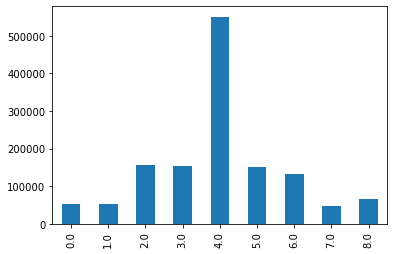

In [6]:
pvds_mikro["selfrile"].cat.remove_categories(['missing / no answer',                     "don't know",
                    'refused to answer', 'no understanding of left-right',
         'question not asked in survey',]).cat.codes.replace(-1,np.nan).value_counts().sort_index().plot(kind='bar')

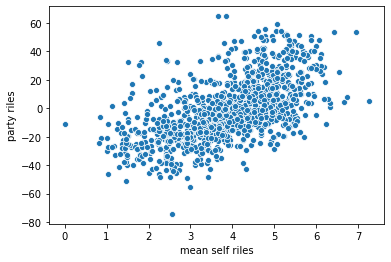

In [7]:
self_rile = pvds_mikro["selfrile"].cat.remove_categories(['missing / no answer',                     "don't know",
                    'refused to answer', 'no understanding of left-right',
         'question not asked in survey',]).cat.codes.replace(-1,np.nan)
party_rile = pvds_mikro["rile"]
year = pvds_mikro["marpor_year"]
party = pvds_mikro["party"]

mask = self_rile.notnull() & party_rile.notnull() & year.notnull() & party.notnull()

mean_self_riles = self_rile[mask].groupby([year[mask],party[mask]]).mean().values
mean_party_riles = party_rile[mask].groupby([year[mask],party[mask]]).mean().values

sns.scatterplot(mean_self_riles,mean_party_riles);
plt.xlabel("mean self riles");
plt.ylabel("party riles");